# Import functions for all processing
Put this notebook inside passive_interval_oddball_202412 project folder. The fllowing is the same as main.py at the beginning.

In [9]:
import sys
import warnings
warnings.filterwarnings('ignore')

import gc
import os
import argparse
from datetime import datetime

from modules import Trialization
from modules import StatTest
from modules.ReadResults import read_ops

def combine_session_config_list(session_config_list):
    list_session_data_path = []
    for sc in session_config_list['list_config']:
        list_session_data_path += [
            os.path.join('results', sc['session_folder'], n)
            for n in sc['list_session_name'].keys()]
    list_session_name = [sc['list_session_name'] for sc in session_config_list['list_config']]
    list_session_name = {k: v for d in list_session_name for k, v in d.items()}
    session_config_list['list_session_name'] = list_session_name
    session_config_list['list_session_data_path'] = list_session_data_path
    return session_config_list

# Define the folder name to the sessions you want to process

## Folder structure

This notebook should be SomeWhere/passive_interval_oddball_202412/quick_start.ipynb.

The data should be SomeWhere/passive_interval_oddball_202412/SubjectName/SessionName.

In this example, we use 1 session from the random paradigm, and the session data is SomeWhere/passive_interval_oddball_202412/test/VTYH02_PPC_20250109_3331Random.

## How to set the sessions going into the analysis

Change list_session_name elements in session_config_test to add or exclude sessions. No need to change anything else at this time.

## It works for both single and cross subject analysis

Here, session_config_test is for cross subject analysis, while session_config_list_test specify the info for one subject. If you are running single subject analysis, list_config in session_config_list_test should have only 1 element for that subject.

## Using short long session as example below

In [21]:
session_config_test = {
        'list_session_name' : {
            #'VTYH02_PPC_20250109_3331Random' : 'random',
            'VTYH02_PPC_20250218_1451ShortLong' : 'short_long',
            'VTYH02_PPC_20250213_1451ShortLong' : 'short_long',
            #'VTYH02_PPC_20250122_4131FixJitterOdd' : 'fix_jitter_odd',
            },
        'session_folder' : 'YH02VT',
        'sig_tag' : 'all',
        'force_label' : None,
        }
session_config_list_test = {
    'list_config': [
        session_config_test,
        ],
    'label_names' : {
        '-1':'Exc',
        '1':'Inh_VIP',
        '2':'Inh_SST',
        },
    'subject_name' : 'YH02VT',
    'output_filename' : 'YH02VT_PPC_passive.html'
    }

Read all saved processsed results.

In [23]:
session_config_list = combine_session_config_list(session_config_list_test)
list_ops = read_ops(session_config_list['list_session_data_path'])
ops = list_ops[0]

from modules.ReadResults import read_all
[list_labels, list_masks,
 list_neural_trials, list_move_offset, list_significance
 ] = read_all(session_config_list, smooth=False)

Reading subject 1/1


100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  3.89it/s]


Set other useful variables.

In [24]:
cate_list = [[-1,1,2]]

import matplotlib.pyplot as plt

label_names = {'-1':'Exc', '1':'Inh_VIP', '2':'Inh_SST'}
cate = [-1,1,2]
roi_id = None
norm_mode='none'
cluster_cmap = plt.cm.hsv
standard = 1
oddball = 1
block = 0
mode = 'post'
temp_folder = 'temp_'+session_config_list['subject_name']
if not os.path.exists(os.path.join('results', 'temp_'+session_config_list['subject_name'])):
    os.makedirs(os.path.join('results', 'temp_'+session_config_list['subject_name']))

Run this to get session configurations. There is only 1 session so the list will have only 1 element. The list structure is using for cross session or cross subject settings.

In [25]:
session_config_list = combine_session_config_list(session_config_list_test)
list_ops = read_ops(session_config_list['list_session_data_path'])
print(session_config_list)
print(f'number of sessions: {len(list_ops)}')

{'list_config': [{'list_session_name': {'VTYH02_PPC_20250218_1451ShortLong': 'short_long', 'VTYH02_PPC_20250213_1451ShortLong': 'short_long'}, 'session_folder': 'YH02VT', 'sig_tag': 'all', 'force_label': None}], 'label_names': {'-1': 'Exc', '1': 'Inh_VIP', '2': 'Inh_SST'}, 'subject_name': 'YH02VT', 'output_filename': 'YH02VT_PPC_passive.html', 'list_session_name': {'VTYH02_PPC_20250218_1451ShortLong': 'short_long', 'VTYH02_PPC_20250213_1451ShortLong': 'short_long'}, 'list_session_data_path': ['results\\YH02VT\\VTYH02_PPC_20250218_1451ShortLong', 'results\\YH02VT\\VTYH02_PPC_20250213_1451ShortLong']}
number of sessions: 2


# Reading data results

Run the following to do trialization if it is not done yet. Otherwise, you can skip this.

Ignore the statistical test results for now.

In [26]:
#for i in range(len(list_ops)):
#    Trialization.run(list_ops[i])

Now you can read all results for analysis as follows. If you want to smooth the trace, set smooth=True instead.

In [27]:
[list_labels, list_masks,list_neural_trials, list_move_offset, list_significance] = read_all(session_config_list, smooth=False)

Reading subject 1/1


100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  4.34it/s]


# Define utility functions

All the following codes are drawed from utils.py. No need to go through the details.



In [30]:

import time
import functools
import tracemalloc
import numpy as np
import rastermap as rm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
from datetime import datetime
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.cluster.hierarchy import dendrogram

from modeling.clustering import get_mean_sem_cluster
from modeling.clustering import clustering_neu_response_mode
from modeling.clustering import remap_cluster_id
from modeling.generative import run_glm_multi_sess
from modeling.quantifications import fit_trf_model

#%% general data processing

# monitor memory usage.
def show_resource_usage(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        print(f'running {func.__name__}')
        tracemalloc.start()
        start = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed = time.perf_counter() - start
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        print(f'--- current time: {datetime.now().strftime("%Y.%m.%d %H:%M:%S")}')
        print(f'--- time cost: {elapsed:.2f}s')
        print(f'--- current memory: {current/1024/1024:.2f} MB')
        print(f'--- memory peak: {peak/1024/1024:.2f} MB')
        return result
    return wrapper

# rescale voltage recordings.
def rescale(data, upper, lower):
    data = data.copy()
    data = ( data - np.nanmin(data) ) / (np.nanmax(data) - np.nanmin(data))
    data = data * (upper - lower) + lower
    return data

# normalization into [0,1].
def norm01(data):
    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data) + 1e-5)

# compute the scale parameters when normalizing data into [0,1].
def get_norm01_params(data):
    x_scale = 1 / (np.nanmax(data) - np.nanmin(data))
    x_offset = - np.nanmin(data) / (np.nanmax(data) - np.nanmin(data))
    x_min = np.nanmin(data)
    x_max = np.nanmax(data)
    return x_scale, x_offset, x_min, x_max

# bin data and return index.
def get_bin_idx(data, bin_win, bin_num):
    bin_size = (bin_win[1] - bin_win[0]) / bin_num
    bins = np.arange(bin_win[0], bin_win[1] + bin_size, bin_size)
    bin_center = bins[:-1] + bin_size / 2
    bin_idx = np.digitize(data, bins) - 1
    return bins, bin_center, bin_idx

# compute mean and sem for average dF/F within given time window.
def get_mean_sem_win(neu_seq, neu_time, c_time, l_time, r_time, mode):
    pct = 50
    l_idx, r_idx = get_frame_idx_from_time(
        neu_time, c_time, l_time, r_time)
    neu_win = neu_seq[:, l_idx:r_idx].copy()
    # mean values in the window.
    if mode == 'mean':
        neu = np.nanmean(neu_win, axis=1)
    # values lower than percentile in the window.
    if mode == 'lower':
        neu = np.array([np.nanmean(ns[ns < np.percentile(ns, pct)]) for ns in neu_win])
    # values higher than percentile in the window.
    if mode == 'higher':
        neu = np.array([np.nanmean(ns[ns > np.percentile(ns, pct)]) for ns in neu_win])
    # compute mean and sem.
    neu_mean = np.nanmean(neu)
    std = np.nanstd(neu)
    count = np.nansum(~np.isnan(np.nanmean(neu_win, axis=1)), axis=0)
    neu_sem = std / np.sqrt(count)
    return neu, neu_mean, neu_sem

# compute mean and sem for 3d array data.
def get_mean_sem(data, win_baseline=None):
    # compute mean.
    m = np.nanmean(data.reshape(-1, data.shape[-1]), axis=0)
    # compute sem.
    std = np.nanstd(data.reshape(-1, data.shape[-1]), axis=0)
    count = np.nansum(~np.isnan(data.reshape(-1, data.shape[-1])), axis=0)
    s = std / np.sqrt(count)
    return m, s

# compute peak time within evaluation window.
def get_peak_time(neu, neu_time, win_peak):
    l_idx, r_idx = get_frame_idx_from_time(neu_time, 0, win_peak[0], win_peak[1])
    peak_time = neu_time[l_idx:r_idx][find_peaks(neu[l_idx:r_idx],distance=1106)[0][0]]
    return peak_time

#%% retreating neural data

# find trials based on stim_labels.
def pick_trial(
        stim_labels,
        img_seq_label,
        standard_types,
        fix_jitter_types,
        oddball_types,
        random_types,
        opto_types,
        frac):
    idx1 = np.isin(stim_labels[:,2], img_seq_label)    if img_seq_label    else np.ones_like(stim_labels[:,2])
    idx2 = np.isin(stim_labels[:,3], standard_types)   if standard_types   else np.ones_like(stim_labels[:,3])
    idx3 = np.isin(stim_labels[:,4], fix_jitter_types) if fix_jitter_types else np.ones_like(stim_labels[:,4])
    idx4 = np.isin(stim_labels[:,5], oddball_types)    if oddball_types    else np.ones_like(stim_labels[:,5])
    idx5 = np.isin(stim_labels[:,6], random_types)     if random_types     else np.ones_like(stim_labels[:,6])
    idx6 = np.isin(stim_labels[:,7], opto_types)       if opto_types       else np.ones_like(stim_labels[:,7])
    idx_fraction = np.random.permutation(np.repeat([1,0], [int(stim_labels.shape[0]*frac), stim_labels.shape[0]-int(stim_labels.shape[0]*frac)]))
    idx = (idx1*idx2*idx3*idx4*idx5*idx6*idx_fraction).astype('bool')
    return idx

# average across subsampling trials.
def sub_sampling_trial(neu_seq, samping_size=3, sampling_times=252):
    # compute number of samples.
    n_samples = int(samping_size*neu_seq.shape[0])+1 if samping_size<1 else samping_size
    # average across ramdom subset of neurons.
    neu_seq_sub = np.zeros([sampling_times, neu_seq.shape[1], neu_seq.shape[2]])
    for ti in range(sampling_times):
        sub_idx = np.random.choice(neu_seq.shape[0], n_samples, replace=False)
        neu_seq_sub[ti,:,:] = np.nanmean(neu_seq[sub_idx,:,:], axis=0)
    return neu_seq_sub

# get trial results across sessions.
def get_multi_sess_neu_trial(
        list_stim_labels,
        neu_cate,
        alignment,
        trial_idx=None,
        trial_param=None,
        mean_sem=True,
        sub_sampling=False,
        frac=1,
    ):
    neu = []
    stim_seq = []
    camera_pupil = []
    pre_isi = []
    post_isi = []
    # pull everything out of the alignment dict once.
    list_stim_seq     = alignment['list_stim_seq']
    list_camera_pupil = alignment['list_camera_pupil']
    list_pre_isi      = alignment['list_pre_isi']
    list_post_isi     = alignment['list_post_isi']
    # decide mode: 1 = only trial_param, 2 = only trial_idx, 3 = both.
    mode = (trial_param is not None) + 2 * (trial_idx is not None)
    if trial_param is not None:
        p0, p1, p2, p3, p4, p5 = trial_param
    # one pass over sessions.
    for i, labels in enumerate(list_stim_labels):
        if mode == 1:
            idx = pick_trial(labels, p0, p1, p2, p3, p4, p5, frac)
        elif mode == 2:
            idx = trial_idx[i]
        elif mode == 3:
            idx = trial_idx[i] * pick_trial(labels, p0, p1, p2, p3, p4, p5, frac)
        else:
            # no trial_param or trial_idx → nothing to do.
            continue
        neu.append(neu_cate[i][idx,...])
        stim_seq.append(list_stim_seq[i][idx,...] )
        camera_pupil.append(list_camera_pupil[i][idx,...])
        pre_isi.append(list_pre_isi[i][idx])
        post_isi.append(list_post_isi[i][idx])
    # total trials & neurons.
    n_trials  = sum(n.shape[0] for n in neu)
    n_neurons = sum(n.shape[1] for n in neu)
    if mean_sem:
        if sub_sampling:
            neu = np.concatenate([sub_sampling_trial(n) for n in neu], axis=1)
            stim_seq = np.nanmean(np.concatenate(stim_seq,     axis=0), axis=0)
            camera_pupil = np.nanmean(np.concatenate(camera_pupil, axis=0), axis=0)
            return [neu, stim_seq, camera_pupil], [n_trials, n_neurons]
        else:
            # per-session means & stds, then concatenate.
            means = [np.nanmean(n, axis=0) for n in neu]
            stds  = [np.nanstd(n,  axis=0) for n in neu]
            mean  = np.concatenate(means, axis=0)
            std   = np.concatenate(stds,  axis=0)
            # collapse sequences & pupil across all trials.
            stim_seq     = np.nanmean(np.concatenate(stim_seq,     axis=0), axis=0)
            camera_pupil = np.nanmean(np.concatenate(camera_pupil, axis=0), axis=0)
            return [mean, std, stim_seq, camera_pupil], [n_trials, n_neurons]
    else:
        return [neu, stim_seq, camera_pupil, pre_isi, post_isi], [n_trials, n_neurons]

# find neuron category and trial data.
def get_neu_trial(
        alignment, list_labels, list_significance, list_stim_labels,
        trial_idx=None, trial_param=None, mean_sem=True, frac=1, sub_sampling=False,
        cate=None, roi_id=None,
        ):
    if cate != None:
        idx = np.concatenate(
            [np.in1d(list_labels[i],cate)*list_significance[i]['r_standard']
             for i in range(len(list_stim_labels))])
        if np.sum(idx) == 0:
            raise ValueError(f'No available neurons in given category {cate}')
        list_neu_seq = alignment['list_neu_seq']
        colors = get_roi_label_color(cate=cate)
        neu_labels = np.concatenate([
            list_labels[i][np.in1d(list_labels[i],cate)*list_significance[i]['r_standard']]
            for i in range(len(list_stim_labels))])
        neu_sig = np.concatenate([
            list_significance[i]['r_standard'][np.in1d(list_labels[i],cate)]
            for i in range(len(list_stim_labels))])
        r_standards = [sig['r_standard'] for sig in list_significance]
        masks = [np.isin(labels, cate) & r_std.astype(bool) for labels, r_std in zip(list_labels, r_standards)]
        neu_cate = [neu_seq[:, mask, :] for neu_seq, mask in zip(list_neu_seq, masks)]
    if roi_id != None:
        colors = get_roi_label_color(list_labels, roi_id=roi_id)
        neu_labels = None
        neu_cate = [np.expand_dims(list_neu_seq[0][:,roi_id,:], axis=1)]
    neu_trial, neu_num = get_multi_sess_neu_trial(
        list_stim_labels, neu_cate, alignment,
        trial_idx=trial_idx, trial_param=trial_param, mean_sem=mean_sem, sub_sampling=sub_sampling, frac=frac)
    return colors, neu_trial, [neu_labels, neu_sig], neu_num

# compute indice with givn time window for dF/F.
def get_frame_idx_from_time(timestamps, c_time, l_time, r_time):
    l_idx = np.searchsorted(timestamps, c_time+l_time)
    r_idx = np.searchsorted(timestamps, c_time+r_time)
    return l_idx, r_idx

# find expected standard fix interval.
def get_expect_interval(stim_labels):
    idx_short = (stim_labels[:,2]>1)*(stim_labels[:,3]==0)
    expect_short = stim_labels[1:,0] - stim_labels[:-1,1]
    expect_short = np.median(expect_short[idx_short[:-1]])
    idx_long = (stim_labels[:,2]>1)*(stim_labels[:,3]==1)
    expect_long = stim_labels[1:,0] - stim_labels[:-1,1]
    expect_long = np.median(expect_long[idx_long[:-1]])
    return expect_short, expect_long

# get index for the first trial of block transition.
def get_block_1st_idx(stim_labels, target, prepost='post'):
    if prepost == 'pre':
        diff = np.diff(stim_labels[:,target], prepend=stim_labels[:,target][0])
    if prepost == 'post':
        diff = np.diff(stim_labels[:,target], prepend=stim_labels[:,target][:2])
        diff = diff[:-1]
    idx_0 = (diff==-1) * (stim_labels[:,target]==0)
    idx_1 = (diff==1) * (stim_labels[:,target]==1)
    return idx_0, idx_1

# find index for epoch.
def get_block_epochs_idx(stim_labels, epoch_len, block_combine=True):
    total_length = len(stim_labels)
    # identify start and end indices for each continuous block
    label_changes = np.diff(stim_labels)
    change_indices = np.where(label_changes != 0)[0]
    block_starts = np.concatenate(([0], change_indices + 1))
    block_ends = np.concatenate((change_indices, [total_length - 1]))
    # dictionaries to collect epoch masks and count epochs per block for each label.
    blocks_dict = {0: [], 1: []}
    blocks_num_epochs = {0: [], 1: []}
    # process each block.
    for start, end in zip(block_starts, block_ends):
        current_label = stim_labels[start]
        block_length = end - start + 1
        num_epochs = block_length // epoch_len
        # build epoch masks for the current block.
        epoch_masks = []
        for i in range(num_epochs):
            mask = np.zeros(total_length, dtype=bool)
            epoch_start = start + i * epoch_len
            epoch_end = epoch_start + epoch_len
            mask[epoch_start:epoch_end] = True
            epoch_masks.append(mask)
        # stack masks.
        block_epochs = np.stack(epoch_masks)
        blocks_dict[current_label].append(block_epochs)
        blocks_num_epochs[current_label].append(num_epochs)
    # trim each block to the minimum number of epochs and stack.
    result = []
    for label in [0, 1]:
        if blocks_dict[label]:
            min_epochs = min(blocks_num_epochs[label])
            trimmed_blocks = [block[:min_epochs] for block in blocks_dict[label]]
            result_array = np.stack(trimmed_blocks)
            # exclude the first block.
            result_array[0,:,:] = False
            result.append(result_array)
        else:
            result.append(np.empty((0, 0, total_length), dtype=bool))
    if block_combine:
        epoch_0s = np.sum(result[0], axis=0).astype('bool')
        epoch_1s = np.sum(result[1], axis=0).astype('bool')
    else:
        epoch_0s = result[0]
        epoch_1s = result[1]
    return epoch_0s, epoch_1s

# find index around transition.
def get_block_transition_idx(stim_labels, trials_around):
    n_trials = len(stim_labels)
    # compute the difference to find transitions.
    diff = np.diff(stim_labels, prepend=stim_labels[0])
    trans_0to1 = np.where(diff == 1)[0]
    trans_1to0 = np.where(diff == -1)[0]
    # only keep transitions that allow a full window.
    valid_0to1 = trans_0to1[(trans_0to1-trials_around>=0) & (trans_0to1+trials_around<n_trials)][1:]
    valid_1to0 = trans_1to0[(trans_1to0-trials_around>=0) & (trans_1to0+trials_around<n_trials)][1:]
    # preallocate boolean masks.
    trans_0to1 = np.zeros((len(valid_0to1), n_trials), dtype=bool)
    trans_1to0 = np.zeros((len(valid_1to0), n_trials), dtype=bool)
    # mark the indices corresponding to the window:
    for i, t in enumerate(valid_0to1):
        trans_0to1[i, t-trials_around:t+trials_around] = True
    for i, t in enumerate(valid_1to0):
        trans_1to0[i, t-trials_around:t+trials_around] = True
    return trans_0to1, trans_1to0

# get index for pre/post short/long oddball.
def get_odd_stim_prepost_idx(stim_labels):
    idx_pre_short = (stim_labels[:,2]==-1) * (stim_labels[:,5]==0) * (stim_labels[:,6]==0)
    idx_pre_long  = (stim_labels[:,2]==-1) * (stim_labels[:,5]==1) * (stim_labels[:,6]==0)
    idx_post_short = np.zeros_like(idx_pre_short)
    idx_post_short[1:] = idx_pre_short[:-1]
    idx_post_long = np.zeros_like(idx_pre_long)
    idx_post_long[1:] = idx_pre_long[:-1]
    idx_pre_short[-1] = False
    idx_pre_long[-1] = False
    return idx_pre_short, idx_pre_long, idx_post_short, idx_post_long

# get index for pre/post image change.
def get_change_prepost_idx(stim_labels):
    idx_pre = np.diff(stim_labels[:,2]<-1, append=0)
    idx_pre[idx_pre==-1] = 0
    idx_pre = idx_pre.astype('bool')
    idx_post = stim_labels[:,2]<-1
    return idx_pre, idx_post

# get index to split concatenated labels for categories.
def get_split_idx(list_labels, list_significance, cate):
    split_idx = [len(list_labels[i][np.in1d(list_labels[i],cate)*list_significance[i]['r_standard']])
        for i in range(len(list_labels))]
    split_idx = np.cumsum(split_idx)[:-1]
    return split_idx

# mark stim around image change and oddball as outlier.
def exclude_odd_stim(stim_labels):
    n = 2
    neg = np.where(stim_labels[:,2] < 0)[0]
    stim_labels_mark = stim_labels.copy()
    for i in neg:
        stim_labels_mark[
            np.max([0, i-n]):np.min([stim_labels.shape[0], i+n+1]),2] = -np.abs(
                stim_labels_mark[np.max([0, i-n]):np.min([stim_labels.shape[0], i+n+1]),2])
    return stim_labels_mark

#%% detailed processing

# compute modulation index.
def get_modulation_index(v_pre, v_post):
    m = (v_post - v_pre) / (np.abs(v_pre) + np.abs(v_post) + 1e-8)
    return m

# get isi based binning average neural response.
def get_isi_bin_neu(
        neu_seq, stim_seq, camera_pupil, isi,
        bin_win, bin_num,
        mean_sem=True
        ):
    # define bins.
    bin_size = (bin_win[1] - bin_win[0]) / bin_num
    bins = np.arange(bin_win[0], bin_win[1] + bin_size, bin_size)
    bin_center = bins[:-1] + bin_size / 2
    list_bin_idx = [np.digitize(i, bins) - 1 for i in isi]
    # compute binned results.
    bin_neu_seq_trial = []
    bin_neu_seq = []
    bin_neu_mean = np.zeros((len(bin_center), neu_seq[0].shape[2]))
    bin_neu_sem = np.zeros((len(bin_center), neu_seq[0].shape[2]))
    bin_stim_seq = np.zeros((len(bin_center), stim_seq[0].shape[1], 2))
    bin_camera_pupil = np.zeros((len(bin_center), camera_pupil[0].shape[1]))
    for i in range(len(bin_center)):
        # get binned neural traces.
        neu_trial = [n[bi==i,:,:] for n, bi in zip(neu_seq, list_bin_idx)]
        neu = [np.nanmean(n, axis=0) for n in neu_trial]
        neu = np.concatenate(neu, axis=0)
        # get binned stimulus timing.
        s_seq = [s[bi==i,:,:] for s, bi in zip(stim_seq, list_bin_idx)]
        s_seq = np.concatenate(s_seq, axis=0)
        s_seq = np.nanmean(s_seq, axis=0)
        # get pupil area.
        c_pupil = [p[bi==i,:] for p, bi in zip(camera_pupil, list_bin_idx)]
        c_pupil = np.concatenate(c_pupil, axis=0)
        c_pupil = np.nanmean(c_pupil, axis=0)
        # collect results.
        bin_neu_seq_trial.append(neu_trial)
        bin_neu_seq.append(neu)
        bin_neu_mean[i,:] = get_mean_sem(neu)[0]
        bin_neu_sem[i,:] = get_mean_sem(neu)[1]
        bin_stim_seq[i,:,:] = s_seq
        bin_camera_pupil[i,:] = c_pupil
    bin_center = bin_center.astype('int32')
    return [bins, bin_center, bin_neu_seq_trial, bin_neu_seq,
            bin_neu_mean, bin_neu_sem, bin_stim_seq, bin_camera_pupil]

# compute synchrnization across time.
def get_neu_sync(neu, win_width):
    sync = []
    for t in range(win_width, neu.shape[1]):
        window_data = neu[:, t-win_width:t]
        # normalization.
        norms = np.linalg.norm(window_data, axis=1, keepdims=True)
        normalized_data = window_data / (norms + 1e-10)
        # pairwise absolute cosine distances.
        cosine_distances = pdist(normalized_data, metric='cosine')
        abs_cosine_distances = np.abs(cosine_distances)
        # convert to overall similarity.
        cos_sim = 1 - abs_cosine_distances
        s = (np.nansum(cos_sim) - neu.shape[0]) / (neu.shape[0]**2 - neu.shape[0])
        sync.append(s)
    return sync

# find expected isi.
def get_expect_time(stim_labels):
    idx_short = (stim_labels[:,2]>1)*(stim_labels[:,3]==0)
    expect_short = stim_labels[1:,0] - stim_labels[:-1,1]
    expect_short = np.median(expect_short[idx_short[:-1]])
    idx_long = (stim_labels[:,2]>1)*(stim_labels[:,3]==1)
    expect_long = stim_labels[1:,0] - stim_labels[:-1,1]
    expect_long = np.median(expect_long[idx_long[:-1]])
    return expect_short, expect_long

# compute calcium transient event timing and average.
def get_ca_transient(dff, time_img):
    pct = 95
    win_peak = 25
    timescale = 1.0
    l_frames = int(20*timescale)
    r_frames = int(150*timescale)
    # calculate the area under this window as a threshold.
    thres = np.percentile(dff, pct) * win_peak
    # find the window larger than baseline.
    def detect_spikes_win(dff_traces):
        # use convolution to calculate the sum of sliding windows.
        sliding_window_sum = np.convolve(dff_traces, np.ones(win_peak), mode='same')
        # compare against the threshold.
        ca_tran_win = (sliding_window_sum > thres).astype(int)
        return ca_tran_win
    # remove outliers.
    def win_thres(ca_tran_win):
        k = 0.5
        # reset start and end.
        if ca_tran_win[0] == 1:
            ca_tran_win[:np.where(ca_tran_win==0)[0][0]] = 0
        if ca_tran_win[-1] == 1:
            ca_tran_win[np.where(np.diff(ca_tran_win, append=0)==1)[0][-1]:] = 0
        ca_tran_diff = np.diff(ca_tran_win, append=0)
        # compute window width.
        win_wid = np.where(ca_tran_diff==-1)[0] - np.where(ca_tran_diff==1)[0]
        # find windows with outlier width.
        lower = np.nanmean(win_wid)-k*np.nanstd(win_wid)
        outlier_idx = (win_wid < lower)
        # reset outlier.
        for i in range(len(win_wid)):
            if outlier_idx[i]:
                ca_tran_win[np.where(ca_tran_diff==1)[0][i]:np.where(ca_tran_diff==-1)[0][i]+1] = 0
        return ca_tran_win
    # only keep the start of a transient.
    def get_tran_time(ca_tran_win):
        ca_tran_idx = (np.diff(ca_tran_win, append=0)==1).astype('int32')
        return ca_tran_idx
    # extract dff traces around calcium transient.
    def get_ca_mean(ca_tran):
        dff_ca_neu = []
        dff_ca_time = []
        for i in range(dff.shape[0]):
            ca_event_time = np.where(ca_tran[i,:]==1)[0]
            # find dff.
            cn = [dff[i,t-l_frames:t+r_frames].reshape(1,-1)
                  for t in ca_event_time
                  if t > l_frames and t < len(time_img)-r_frames]
            cn = np.concatenate(cn, axis=0) if len(cn) > 0 else np.array([np.nan])
            # find time.
            ct = [time_img[t-l_frames:t+r_frames].reshape(1,-1)-time_img[t]
                  for t in ca_event_time
                  if t > l_frames and t < len(time_img)-r_frames]
            ct = np.concatenate(ct, axis=0) if len(ct) > 0 else np.array([np.nan])
            ct = np.nanmean(ct, axis=0) if not np.isnan(np.mean(ct)) else np.array([np.nan])
            # collect.
            dff_ca_neu.append(cn)
            dff_ca_time.append(ct)
        dff_ca_time = np.concatenate([t.reshape(1,-1) for t in dff_ca_time], axis=0)
        dff_ca_time = np.nanmean(dff_ca_time, axis=0)
        return dff_ca_neu, dff_ca_time
    # compute transient events.
    ca_tran = np.zeros_like(dff)
    for i in range(dff.shape[0]):
        ca_tran_win = detect_spikes_win(dff[i,:])
        ca_tran_win = win_thres(ca_tran_win)
        ca_tran[i,:] = get_tran_time(ca_tran_win)
    # compute average.
    dff_ca_neu, dff_ca_time = get_ca_mean(ca_tran)
    # get the total number of events for each neurons.
    n_ca = np.nansum(ca_tran, axis=1)
    return n_ca, dff_ca_neu, dff_ca_time

# compute calcium transient event timing and average with multiple sessions.
def get_ca_transient_multi_sess(list_neural_trials):
    list_dff = [nt['dff'] for nt in list_neural_trials] 
    list_time = [nt['time'] for nt in list_neural_trials]
    list_n_ca = []
    list_dff_ca_neu = []
    list_dff_ca_time = []
    for i in range(len(list_dff)):
        n_ca, dff_ca_neu, dff_ca_time = get_ca_transient(
            list_dff[i], list_time[i])
        list_n_ca.append(n_ca)
        list_dff_ca_neu += dff_ca_neu
        list_dff_ca_time.append(dff_ca_time.reshape(1,-1))
    list_n_ca = np.concatenate(list_n_ca)
    list_dff_ca_time = np.nanmean((np.concatenate(list_dff_ca_time, axis=0)), axis=0)
    return list_n_ca, list_dff_ca_neu, list_dff_ca_time

# strech data to target time stamps for temporal scaling for 2d data.
def get_temporal_scaling_data(data, t_org, t_target):
    # map to target time stamps.
    t_mapped = (t_target - t_target[0]) / (t_target[-1] - t_target[0]) * (t_org[-1] - t_org[0]) + t_org[0]
    # find the target inserted index.
    idx_right = np.searchsorted(t_org, t_mapped)
    idx_right = np.clip(idx_right, 1, len(t_org)-1)
    idx_left = idx_right - 1
    # compute the fractional distance between the two original time stamps.
    t_left = t_org[idx_left]
    t_right = t_org[idx_right]
    weights = (t_mapped - t_left) / (t_right - t_left)
    # lienar interpolation for each row.
    left_vals = data[:, idx_left]
    right_vals = data[:, idx_right]
    data_scaled = left_vals + weights * (right_vals - left_vals)
    return data_scaled

# compute scaled data for single trial response across sessions.
def get_temporal_scaling_trial_multi_sess(neu_seq, stim_seq, neu_time, target_isi):
    # compute mean time stamps.
    stim_seq_target = np.nanmean(np.concatenate(stim_seq, axis=0),axis=0)
    c_idx = int(stim_seq_target.shape[0]/2)
    # target isi before.
    target_l_pre, target_r_pre = get_frame_idx_from_time(
        neu_time, 0,
        -target_isi,
        stim_seq_target[c_idx,0])
    # target stimulus.
    target_l_stim, target_r_stim = get_frame_idx_from_time(
        neu_time, 0,
        stim_seq_target[c_idx,0],
        stim_seq_target[c_idx,1])
    # target isi after.
    target_l_post, target_r_post = get_frame_idx_from_time(
        neu_time, 0,
        stim_seq_target[c_idx,1],
        stim_seq_target[c_idx,1]+target_isi)
    # compute trial wise temporal scaling.
    scale_neu_seq = []
    for si in range(len(neu_seq)):
        scale_ns = np.zeros((neu_seq[si].shape[0], neu_seq[si].shape[1], target_r_post-target_l_pre))
        for ti in range(neu_seq[si].shape[0]):
            # trial isi before.
            l_pre, r_pre = get_frame_idx_from_time(
                neu_time, 0,
                stim_seq[si][ti,c_idx-1,1],
                stim_seq[si][ti,c_idx,0])
            # trial stimulus.
            l_stim, r_stim = get_frame_idx_from_time(
                neu_time, 0,
                stim_seq[si][ti,c_idx,0],
                stim_seq[si][ti,c_idx,1])
            # trial isi after.
            l_post, r_post = get_frame_idx_from_time(
                neu_time, 0,
                stim_seq[si][ti,c_idx,1],
                stim_seq[si][ti,c_idx+1,0])
            # compute scaled data.
            scale_ns[ti,:,:] = np.concatenate([
                get_temporal_scaling_data(
                    neu_seq[si][ti,:,l_pre:r_pre],
                    neu_time[l_pre:r_pre],
                    neu_time[target_l_pre:target_r_pre]),
                get_temporal_scaling_data(
                    neu_seq[si][ti,:,l_stim:r_stim],
                    neu_time[l_stim:r_stim],
                    neu_time[target_l_stim:target_r_stim]),
                get_temporal_scaling_data(
                    neu_seq[si][ti,:,l_post:r_post],
                    neu_time[l_post:r_post],
                    neu_time[target_l_post:target_r_post]),
                ], axis=1)
        # collect single session results.
        scale_neu_seq.append(scale_ns)
    return scale_neu_seq

# run statistics test and get significance level.
def get_stat_test(data_1, data_2, stat_test):
    p_thres = np.array([5e-2, 5e-4, 5e-6])
    if stat_test == 'mean':
        _, p = mannwhitneyu(data_1, data_2)
    if stat_test == 'var':
        _, p = levene(data_1, data_2)
    r = np.sum(p < p_thres)
    return p, r

# statistics test for response in evaluation windows.
def get_win_mag_quant_stat_test(neu_seq_1, neu_seq_2, neu_time, c_time, win_eval, stat_test):
    baseline_correction = False
    mode = ['lower', 'mean', 'mean', 'mean']
    # get window data.
    neu_1 = [get_mean_sem_win(
        neu_seq_1.reshape(-1, neu_seq_1.shape[-1]),
        neu_time, c_time, win_eval[i][0], win_eval[i][1], mode=mode[i])
        for i in range(4)]
    neu_2 = [get_mean_sem_win(
        neu_seq_2.reshape(-1, neu_seq_2.shape[-1]),
        neu_time, c_time, win_eval[i][0], win_eval[i][1], mode=mode[i])
        for i in range(4)]
    # baseline correction.
    if baseline_correction:
        neu_1 = [neu_1[i][0] - neu_1[0][1] for i in [1,2,3]]
        neu_2 = [neu_2[i][0] - neu_2[0][1] for i in [1,2,3]]
    else:
        neu_1 = [neu_1[i][0] for i in [1,2,3]]
        neu_2 = [neu_2[i][0] for i in [1,2,3]]
    # run statistics test.
    p = np.array([get_stat_test(n1, n2, stat_test)[0] for n1, n2 in zip(neu_1, neu_2)])
    r = np.array([get_stat_test(n1, n2, stat_test)[1] for n1, n2 in zip(neu_1, neu_2)])
    return p, r

# compute correlation between rows.
def get_row_corr(x, y):
    xm = x
    ym = y
    num = np.sum(xm * ym, axis=1)
    den = np.sqrt(np.sum(xm*xm, axis=1) * np.sum(ym*ym, axis=1))
    c = num / den
    return c

# average across subsampling neurons.
def sub_sampling_neuron(neu_seq):
    samping_size = 0.2
    sampling_times = 50
    # compute number of samples.
    n_samples = int(samping_size*neu_seq.shape[0])+1
    # average across ramdom subset of neurons.
    neu_seq_sub = np.zeros([sampling_times, neu_seq.shape[1]])
    for qi in range(sampling_times):
        sub_idx = np.random.choice(neu_seq.shape[0], n_samples, replace=False)
        neu_seq_sub[qi,:] = np.nanmean(neu_seq[sub_idx,:], axis=0)
    return neu_seq_sub


#%% plotting

# get color from label.
def get_roi_label_color(labels=None, cate=None, roi_id=None):
    if (roi_id != None and labels[roi_id] == -1) or (cate == [-1]):
        color0 = 'dimgrey'
        color1 = 'deepskyblue'
        color2 = 'royalblue'
        cmap = mcolors.LinearSegmentedColormap.from_list(
            'yicong_will_love_you_forever',
            ['lemonchiffon', 'royalblue', 'black'])
    if (roi_id != None and labels[roi_id] == 1) or (cate == [1]):
        color0 = 'dimgrey'
        color1 = 'chocolate'
        color2 = 'crimson'
        cmap = mcolors.LinearSegmentedColormap.from_list(
            'yicong_will_love_you_forever',
            ['lemonchiffon', 'crimson', 'black'])
    if (roi_id != None and labels[roi_id] == 2) or (cate == [2]):
        color0 = 'dimgrey'
        color1 = 'mediumseagreen'
        color2 = 'forestgreen'
        cmap = mcolors.LinearSegmentedColormap.from_list(
            'yicong_will_love_you_forever',
            ['lemonchiffon', 'forestgreen', 'black'])
    if len(cate) > 1:
        color0 = 'dimgrey'
        color1 = 'hotpink'
        color2 = 'darkviolet'
        cmap = mcolors.LinearSegmentedColormap.from_list(
            'yicong_will_love_you_forever',
            ['lemonchiffon', 'violet', 'black'])
    return color0, color1, color2, cmap

# return colors from dim to dark with a base color.
def get_cmap_color(n_colors, base_color=None, cmap=None, return_cmap=False):
    c_margin = 0.05
    if base_color != None:
        cmap = mcolors.LinearSegmentedColormap.from_list(
            None, base_color)
    if cmap != None:
        pass
    colors = cmap(np.linspace(c_margin, 1 - c_margin, n_colors))
    colors = [mcolors.to_hex(color, keep_alpha=True) for color in colors]
    if return_cmap:
        return cmap, colors
    else:
        return colors

# sort each row in a heatmap.
def sort_heatmap_neuron(neu_seq_sort, sort_method):
    win_conv = 9
    n_clusters = 3
    locality = 1
    # smooth values.
    smoothed = np.array(
        [np.convolve(row, np.ones(win_conv)/win_conv, mode='same')
         for row in neu_seq_sort])
    if sort_method == 'rastermap':
        # fit model.
        model = rm.Rastermap(n_clusters=n_clusters, locality=locality)
        model.fit(smoothed)
        # get ordering.
        sorted_idx = model.isort
    if sort_method == 'peak_timing':
        # get peak timing.
        peak_time = np.argmax(smoothed, axis=1).reshape(-1)
        # combine and sort.
        sorted_idx = peak_time.argsort()
    if sort_method == 'shuffle':
        sorted_idx = np.random.permutation(np.arange(smoothed.shape[0]))
    return sorted_idx

# apply colormap.
def apply_colormap(data, norm_mode, data_share):
    hm_cmap = plt.cm.hot
    pct = 1
    # no valid data found.
    if len(data) == 0:
        hm_data = np.zeros((0, data.shape[1], 3))
        hm_norm = None
        return hm_data, hm_norm, hm_cmap
    else:
        # binary heatmap.
        if norm_mode == 'binary':
            hm_norm = mcolors.Normalize(vmin=0, vmax=1)
            cs = get_cmap_color(3, cmap=hm_cmap)
            hm_cmap = mcolors.LinearSegmentedColormap.from_list(None, ['#FCFCFC', cs[1]])
        else:
            # no normalization.
            if norm_mode == 'none':
                hm_norm = mcolors.Normalize(vmin=np.nanpercentile(data, pct), vmax=np.nanpercentile(data, 100-pct))
                data = np.clip(data, np.nanpercentile(data, pct), np.nanpercentile(data, 100-pct))
                data = norm01(data)
            # normalized into [0,1].
            elif norm_mode == 'minmax':
                for i in range(data.shape[0]):
                    data[i,:] = norm01(data[i,:])
                hm_norm = mcolors.Normalize(vmin=0, vmax=1)
            # share the global scale.
            elif norm_mode == 'share':
                hm_norm = mcolors.Normalize(vmin=np.nanpercentile(data_share, pct), vmax=np.nanpercentile(data_share, 100-pct))
                data = np.clip(data, np.nanpercentile(data_share, pct), np.nanpercentile(data_share, 100-pct))
                data = norm01(data)
            # handle errors.
            else:
                raise ValueError('norm_mode can only be [binary, none, minmax, share].')
        hm_cmap.set_bad(color='white')
        hm_data = hm_cmap(data)
        hm_data = hm_data[..., :3]
    return hm_data, hm_norm, hm_cmap

# hide all axis.
def hide_all_axis(ax):
    ax.tick_params(tick1On=False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# generate random rotation matrix for 3d dynamics.
def get_random_rotate_mat_3d():
    u1, u2, u3 = np.random.random(3)
    s1, s2 = np.sqrt(1.0 - u1), np.sqrt(u1)
    th1, th2 = 2.0*np.pi*u2, 2.0*np.pi*u3
    x = s1 * np.sin(th1)
    y = s1 * np.cos(th1)
    z = s2 * np.sin(th2)
    w = s2 * np.cos(th2)
    rm = np.array([
        [1-2*(y*y+z*z), 2*(x*y-z*w),   2*(x*z+y*w)],
        [2*(x*y+z*w),   1-2*(x*x+z*z), 2*(y*z-x*w)],
        [2*(x*z-y*w),   2*(y*z+x*w),   1-2*(x*x+y*y)]])
    return rm

# adjust layout for isi example epoch.
def adjust_layout_isi_example_epoch(ax, trial_win, bin_win):
    ax.tick_params(tick1On=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('trial #')
    ax.set_ylabel('interval (ms)')
    ax.set_xlim(trial_win)
    ax.set_ylim(bin_win)
    ax.set_yticks(500*np.arange((bin_win[0]+50)/500, (bin_win[1]-50)/500+1).astype('int32'))
    ax.set_yticklabels(
        500*np.arange((bin_win[0]+50)/500, (bin_win[1]-50)/500+1).astype('int32'))

# adjust layout for grand average neural traces.
def adjust_layout_neu(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('dF/F (z-scored)')
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_locator(mtick.MaxNLocator(nbins=1))

# adjust layout for grand average neural traces for clustering.
def adjust_layout_cluster_neu(ax, n_clusters, xlim):
    ax.tick_params(axis='y', tick1On=False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_xticks([0])
    ax.set_yticks([])
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_locator(mtick.MaxNLocator(nbins=3))

# adjust layout for scatter comparison.
def adjust_layout_scatter(ax, upper, lower):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
    ax.set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(mtick.MaxNLocator(nbins=2))
    ax.yaxis.set_major_locator(mtick.MaxNLocator(nbins=2))

# adjust layout for heatmap.
def adjust_layout_heatmap(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# adjust layout for 2d latent dynamics.
def adjust_layout_2d_latent(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(mtick.MaxNLocator(nbins=2))
    ax.yaxis.set_major_locator(mtick.MaxNLocator(nbins=2))
    
# adjust layout for 3d latent dynamics.
def adjust_layout_3d_latent(ax):
    ax.grid(False)
    ax.view_init(elev=15, azim=15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

# add legend into subplots.
def add_legend(ax, colors, labels, n_trials, n_neurons, n_sessions, loc, dim=2):
    if dim == 2:
        plot_args = [[],[]]
    if dim == 3:
        plot_args = [[],[],[]]
    handles = []
    if colors != None and labels != None:
        handles += [
            ax.plot(*plot_args, lw=0, color=colors[i], label=labels[i])[0]
            for i in range(len(labels))]
    if n_trials != None and n_neurons != None:
        handles += [
            ax.plot(*plot_args, lw=0, color='black', label=r'$n_{trial}=$'+str(n_trials))[0],
            ax.plot(*plot_args, lw=0, color='black', label=r'$n_{neuron}=$'+str(n_neurons))[0],
            ax.plot(*plot_args, lw=0, color='black', label=r'$n_{session}=$'+str(n_sessions))[0]]
    ax.legend(
        loc=loc,
        handles=handles,
        labelcolor='linecolor',
        frameon=False,
        framealpha=0)

# add heatmap colorbar.
def add_heatmap_colorbar(ax, cmap, norm, label, yticklabels=None):
    if ax != None:
        hide_all_axis(ax)
        cax = ax.inset_axes([0.3, 0.1, 0.2, 0.8], transform=ax.transAxes)
        if norm == None:
            norm = mcolors.Normalize(vmin=0, vmax=1)
        cbar = ax.figure.colorbar(
            plt.cm.ScalarMappable(
                cmap=cmap,
                norm=norm),
            cax=cax)
        cbar.outline.set_linewidth(0.25)
        cbar.ax.set_ylabel(label, rotation=90, labelpad=10)
        cbar.ax.tick_params(axis='y')
        cbar.ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
        cbar.ax.yaxis.set_major_locator(
            mtick.FixedLocator([norm.vmin+0.2*(norm.vmax-norm.vmin),
                                norm.vmax-0.2*(norm.vmax-norm.vmin)]))
        if yticklabels != None:
            cbar.ax.set_yticklabels(yticklabels)

#%% basic plotting utils class


In [32]:
min_num_trial = 5
cluster_up_cmap = plt.cm.spring
cluster_dn_cmap = plt.cm.winter
latent_cmap = plt.cm.nipy_spectral
random_bin_cmap = plt.cm.gist_ncar
cross_day_cmap = plt.cm.gnuplot_r
stat_sym = ['n.s.', '*', '**', '***']
heatmap_sort_frac = 0.5

@show_resource_usage
def run_glm():
    # define kernel window.
    kernel_win = [-1500,1500]
    l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, kernel_win[0], kernel_win[1])
    kernel_time = alignment['neu_time'][l_idx:r_idx]
    l_idx = np.searchsorted(alignment['neu_time'], 0) - l_idx
    r_idx = r_idx - np.searchsorted(alignment['neu_time'], 0)
    # collect data.
    list_dff = [nt['dff'] for nt in list_neural_trials]
    list_neu_time = [nt['time'] for nt in list_neural_trials]
    list_input_time  = [nt['vol_time'] for nt in list_neural_trials]
    list_input_value = [nt['vol_stim_vis'] for nt in list_neural_trials]
    list_stim_labels = [nt['stim_labels'] for nt in list_neural_trials]
    # fit glm model.
    kernel_all = run_glm_multi_sess(
        list_dff, list_neu_time,
        list_input_time, list_input_value, list_stim_labels,
        l_idx, r_idx)
    glm = {
        'kernel_time': kernel_time,
        'kernel_all': kernel_all,
        }
    return glm

def run_clustering( n_up, n_dn):
    r2_thres = 0.4
    # get data within range.
    z_idx = get_frame_idx_from_time(glm['kernel_time'], 0, -100, 0)[0]
    neu_seq_l = glm['kernel_all'][:,:z_idx]
    neu_time_l = glm['kernel_time'][:z_idx]
    neu_seq_r = glm['kernel_all'][:,z_idx:]
    neu_time_r = glm['kernel_time'][z_idx:]
    # fit response model.
    [trf_param_up, pred_up, r2_all_up,
     trf_param_dn, pred_dn, r2_all_dn] = fit_trf_model(
         neu_seq_l, neu_time_l, neu_seq_r, neu_time_r)
    # initilize clustering.
    n_clusters = n_up + n_dn
    cluster_id = np.ones(glm['kernel_all'].shape[0]) * -1
    # get good ramp index.
    idx_up = (r2_all_up > r2_thres) * (r2_all_up > r2_all_dn)
    idx_dn = (r2_all_dn > r2_thres) * (r2_all_dn > r2_all_up)
    # run clustering.
    cluster_id_up = clustering_neu_response_mode(trf_param_up[idx_up,3].reshape(-1,1), n_up, 'kmeans')
    cluster_id_dn = clustering_neu_response_mode(trf_param_dn[idx_dn,3].reshape(-1,1), n_dn, 'kmeans')
    # relabel based on temporal receptive field.
    sorted_up = np.argsort([np.nanmean(trf_param_up[idx_up,3][cluster_id_up==ci]) for ci in range(n_up)])
    sorted_dn = np.argsort([np.nanmean(trf_param_dn[idx_dn,3][cluster_id_dn==ci]) for ci in range(n_dn)])
    map_up = {val: i for i, val in enumerate(sorted_up)}
    map_dn = {val: i for i, val in enumerate(sorted_dn)}
    cluster_id_up = np.vectorize(map_up.get)(cluster_id_up)
    cluster_id_dn = np.vectorize(map_dn.get)(cluster_id_dn)
    cluster_id[idx_up] = cluster_id_up
    cluster_id[idx_dn] = cluster_id_dn+n_up
    return cluster_id

def plot_cluster_type_percentage( ax):
    #fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    colors = ['hotpink', 'coral', 'cornflowerblue', 'mediumseagreen']
    lbls = ['stim-act-fast','stim-act-slow', 'stim-inh-fast', 'stim-inh-slow']
    #num = [1374, 455+1821, 572+420, 1875+1068+593]
    num = [548+923, 734+475, 265+301, 250+701+734]
    ax.pie(
        num,
        labels=[f'{lbls[i]}' for i in range(4)],
        colors=colors,
        autopct='%1.1f%%',
        wedgeprops={'linewidth': 1, 'edgecolor':'white', 'width':0.2})

def plot_mean_sem( ax, t, m, s, c, l=None, a=1.0):
    ax.plot(t, m, color=c, label=l, alpha=a)
    ax.fill_between(t, m - s, m + s, color=c, alpha=0.25, edgecolor='none')
    ax.set_xlim([np.min(t), np.max(t)])

def plot_half_violin( ax, data, x, color, side):
    p = ax.violinplot(data[~np.isnan(data)], positions=[x], widths=1, showextrema=False)
    v = p['bodies'][0].get_paths()[0].vertices
    p['bodies'][0].set(facecolor=color, alpha=0.3)
    p['bodies'][0].set_edgecolor(color)
    p['bodies'][0].set_linewidth(1)
    m = v[:,0].mean()
    v[:,0] = np.minimum(v[:,0], m) if side.lower().startswith('l') else np.maximum(v[:,0], m)

def plot_vol( ax, st, sv, c, u, l):
    v = np.mean(sv, axis=0)
    v = rescale(v, u, l)
    ax.plot(st, v, color=c, lw=0.5, linestyle=':')

def plot_pupil( ax, nt, cp, c, u, l):
    cp = rescale(cp, u, l)
    ax.plot(nt, cp, color=c, lw=0.5, linestyle=':')

def plot_dist( ax, data, c, cumulative):
    bins = 25
    # raw counts
    counts, bin_edges = np.histogram(data, bins=bins)
    # fraction of samples in each bin.
    total = counts.sum()
    fractions = counts / total  
    # bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # cumulative.
    if cumulative:
        fractions = np.cumsum(fractions)
    # plot line.
    ax.plot(bin_centers, fractions, color=c)

def plot_scatter( ax, q1, q2, c):
    # subsampling if lengths differ.
    if len(q1) > len(q2):
        q1 = q1[np.random.choice(len(q1), size=len(q2), replace=False)]
    if len(q1) < len(q2):
        q2 = q2[np.random.choice(len(q2), size=len(q1), replace=False)]          
    # find bounds.
    upper = np.nanmax([q1, q2])
    lower = np.nanmin([q1, q2])
    # plot scatter.
    ax.scatter(q1, q2, color=c, s=1, alpha=0.5)
    # plot unit line.
    ax.plot(
        np.linspace(lower,upper,1106),
        np.linspace(lower,upper,1106),
        lw=1, linestyle=':', color='#2C2C2C')
    # plot mean value.
    ax.scatter(
        np.nanmean(q1), np.nanmean(q2),
        color='black', marker='x', s=10)
    # plot statistics test.
    r_m = get_stat_test(q1, q2, 'mean')[1]
    r_v = get_stat_test(q1, q2, 'var')[1]
    ax.text(
        upper-0.05*(upper-lower), upper-0.4*(upper-lower), stat_sym[r_m],
        ha='center', va='center')
    ax.text(
        upper-0.05*(upper-lower), upper-0.6*(upper-lower), stat_sym[r_v],
        ha='center', va='center')
    # adjust layouts.
    adjust_layout_scatter(ax, upper, lower)

def plot_glm_kernel( ax, kernel_all, cluster_id, color, height):
    gap = 0.05
    # define layouts.
    ax.axis('off')
    ax_lbl = ax.inset_axes([0, 0, 0.4, height], transform=ax.transAxes)
    ax_glm = ax.inset_axes([0.5, 0, 0.5, height], transform=ax.transAxes)
    # get cluster average.
    glm_mean, glm_sem = get_mean_sem_cluster(kernel_all, n_clusters, cluster_id)
    norm_params = [get_norm01_params(glm_mean[ci,:]) for ci in range(n_clusters)]
    # plot results.
    ax_glm.axvline(0, color=color, lw=1, linestyle='--')
    plot_cluster_mean_sem(
        ax_glm, glm_mean, glm_sem, glm['kernel_time'],
        norm_params, None, None, [color]*n_clusters,
        [np.nanmin(glm['kernel_time']), np.nanmax(glm['kernel_time'])])
    # adjust layouts.
    ax_lbl.spines['right'].set_visible(False)
    ax_lbl.spines['top'].set_visible(False)
    ax_lbl.spines['bottom'].set_visible(False)
    ax_lbl.set_ylim([-0.2, n_clusters+0.1])
    ax_lbl.set_xticks([])
    ax_lbl.set_yticks([(1-2*gap)+gap+n_clusters-ci-1.5 for ci in range(n_clusters)])
    ax_lbl.set_yticklabels(np.arange(n_clusters))
    ax_lbl.set_ylabel('Cluster ID')
    ax_glm.set_xlabel('time since stim (ms)')
    
def plot_heatmap_neuron(
         ax_hm, ax_cb, neu_seq, neu_time, neu_seq_sort,
        sort_method='rastermap',
        norm_mode=None, neu_seq_share=None,
        cbar_label=None,
        ):
    n_yticks = 2
    max_pixel = 258
    if len(neu_seq) > 0:
        # exclude pure nan row.
        neu_idx = np.where(~np.all(np.isnan(neu_seq), axis=1))[0]
        neu_seq = neu_seq[neu_idx,:].copy()
        neu_seq_sort = neu_seq_sort[neu_idx,:].copy()
        # sort heatmap.
        sorted_idx = sort_heatmap_neuron(neu_seq_sort, sort_method=sort_method)
        data = neu_seq[sorted_idx,:].copy()
        n_neurons = data.shape[0]
        # reduce pixels.
        nbin = int(neu_seq.shape[0] / max_pixel)
        data = rm.utils.bin1d(data, bin_size=nbin, axis=0)
        # compute share scale if give.
        if neu_seq_share != None:
            data_share = np.concatenate(neu_seq_share, axis=0)
        else:
            data_share = np.nan
        # prepare heatmap.
        hm_data, hm_norm, hm_cmap = apply_colormap(data, norm_mode, data_share)
        # plot heatmap.
        ax_hm.imshow(
            hm_data,
            extent=[neu_time[0], neu_time[-1], 1, hm_data.shape[0]],
            interpolation='nearest', aspect='auto')
        # adjust layouts.
        adjust_layout_heatmap(ax_hm)
        ax_hm.set_ylabel('neuron id (sorted)')
        ax_hm.tick_params(axis='y', labelrotation=90)
        ax_hm.set_yticks((((np.arange(n_yticks)+0.5)/n_yticks)*data.shape[0]).astype('int32'))
        ax_hm.set_yticklabels((((np.arange(n_yticks)+0.5)/n_yticks)*n_neurons).astype('int32'))
        # add colorbar.
        add_heatmap_colorbar(ax_cb, hm_cmap, hm_norm, 'dF/F')

def plot_heatmap_trial(
         ax_hm, ax_cb, neu_seq, neu_time,
        norm_mode=None, neu_seq_share=None,
        cbar_label=None,
        ):
    n_yticks = 2
    max_pixel = 258
    if len(neu_seq) > 0:
        # exclude pure nan row.
        neu_idx = np.where(~np.all(np.isnan(neu_seq), axis=1))[0]
        neu_seq = neu_seq[neu_idx,:].copy()
        # reduce pixels.
        nbin = int(neu_seq.shape[0] / max_pixel)
        data = rm.utils.bin1d(neu_seq, bin_size=nbin, axis=0)
        # compute share scale if give.
        if neu_seq_share != None:
            data_share = np.concatenate(neu_seq_share, axis=0)
            data_share = rm.utils.bin1d(data_share, bin_size=nbin, axis=0)
        else:
            data_share = np.nan
        # prepare heatmap.
        hm_data, hm_norm, hm_cmap = apply_colormap(data, norm_mode, data_share)
        # plot heatmap.
        ax_hm.imshow(
            hm_data,
            extent=[neu_time[0], neu_time[-1], 1, hm_data.shape[0]],
            interpolation='nearest', aspect='auto')
        # adjust layouts.
        adjust_layout_heatmap(ax_hm)
        ax_hm.set_yticks((((np.arange(n_yticks)+0.5)/n_yticks)*data.shape[0]).astype('int32'))
        ax_hm.set_yticklabels((((np.arange(n_yticks)+0.5)/n_yticks)*neu_seq.shape[0]).astype('int32'))
        # add colorbar.
        add_heatmap_colorbar(ax_cb, hm_cmap, hm_norm, 'dF/F')

def plot_win_mag_quant_win_eval(
         ax, win_eval, color, xlim, baseline=True
        ):
    if baseline:
        ax.plot(win_eval[0], [1,1], color=color, linestyle=':', marker='|')
    for i in range(len(win_eval)-1):
        ax.plot(win_eval[i+1], [1,1], color=color, marker='|')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim([0,1.1])
    ax.set_yticks([])
            
def plot_win_mag_quant(
         ax, neu_seq, neu_time,
        win_eval, color, c_time, offset,
        ):
    mode = ['lower', 'mean', 'mean', 'mean']
    # compute response within window.
    quant = [get_mean_sem_win(
        neu_seq.reshape(-1, neu_seq.shape[-1]),
        neu_time, c_time, win_eval[i][0], win_eval[i][1], mode=mode[i])
        for i in range(4)]
    m = np.array([quant[i][1] for i in range(4)])
    s = np.array([quant[i][2] for i in range(4)])
    # plot errorbar.
    for i in [1,2,3]:
        ax.errorbar(
            i + offset,
            m[i]-m[0], s[i],
            color=color,
            capsize=2, marker='o', linestyle='none',
            markeredgecolor='white', markeredgewidth=0.1)
    # adjust layouts.
    ax.tick_params(tick1On=False)
    ax.tick_params(axis='x', labelrotation=90)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('evoked magnitude')
    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['early', 'late', 'post'])
    ax.set_xlim([0.5, 3.5])

def plot_multi_sess_decoding_num_neu(
         ax,
        sampling_nums, acc_model, acc_chance,
        color1, color2
        ):
    # compute mean and sem.
    acc_mean_model  = np.array([get_mean_sem(a)[0] for a in acc_model]).reshape(-1)
    acc_sem_model   = np.array([get_mean_sem(a)[1] for a in acc_model]).reshape(-1)
    acc_mean_chance = np.array([get_mean_sem(a)[0] for a in acc_chance]).reshape(-1)
    acc_sem_chance  = np.array([get_mean_sem(a)[1] for a in acc_chance]).reshape(-1)
    # plot results.
    plot_mean_sem(ax, sampling_nums, acc_mean_model,  acc_sem_model,  color2, 'model')
    plot_mean_sem(ax, sampling_nums, acc_mean_chance, acc_sem_chance, color1, 'chance')
    ax.tick_params(tick1On=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('number of sampled neurons')
    add_legend(ax, [color2,color1], ['model','chance'], 'upper left')

def plot_multi_sess_decoding_slide_win(
         ax,
        eval_time, acc_model, acc_chance,
        color1, color2
        ):
    # compute mean and sem.
    acc_mean_model  = np.array([get_mean_sem(a)[0] for a in acc_model]).reshape(-1)
    acc_sem_model   = np.array([get_mean_sem(a)[1] for a in acc_model]).reshape(-1)
    acc_mean_chance = np.array([get_mean_sem(a)[0] for a in acc_chance]).reshape(-1)
    acc_sem_chance  = np.array([get_mean_sem(a)[1] for a in acc_chance]).reshape(-1)
    # compute bounds.
    upper = np.nanmax([acc_mean_model,acc_mean_chance]) + np.nanmax([acc_sem_model,acc_sem_chance])
    lower = np.nanmin([acc_mean_model,acc_mean_chance]) - np.nanmax([acc_sem_model,acc_sem_chance])
    # plot results.
    plot_mean_sem(ax, eval_time, acc_mean_model,  acc_sem_model,  color2, 'model')
    plot_mean_sem(ax, eval_time, acc_mean_chance, acc_sem_chance, color1, 'chance')
    ax.tick_params(tick1On=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
    add_legend(ax, [color2,color1], ['model','chance'], 'upper left')

def plot_cluster_neu_fraction_in_cluster( ax, cluster_id, color):
    bar_width = 0.2
    # get fraction in each cluster.
    num = np.array([np.nansum(cluster_id==i) for i in range(n_clusters)])
    fraction = num / (np.nansum(num) + 1e-5)
    # plot bars.
    ax.axis('off')
    ax = ax.inset_axes([0, 0, 0.6, 1], transform=ax.transAxes)
    for ci in range(n_clusters):
        ax.barh(
            n_clusters-ci-1+0.5, fraction[ci],
            left=0,
            edgecolor='white',
            height=bar_width,
            color=color)
        ax.text(0.01, n_clusters-ci-1+0.7,
                f'{fraction[ci]:.2f}, n={num[ci]}',
                ha='left', va='center', color='#2C2C2C')
    # adjust layouts.
    ax.tick_params(tick1On=False)
    ax.tick_params(axis='y', labelrotation=90)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0,np.nanmax(fraction)])
    ax.set_ylim([-0.2, n_clusters+0.1])
    ax.set_xlabel('fraction of neurons')

def plot_cluster_cate_fraction_in_cluster( ax, cluster_id, neu_labels, label_names, color=None):
    bar_width = 0.5
    cate_eval = [int(k) for k in label_names.keys()]
    if color != None:
        cate_color = [color]*len(cate_eval) 
    else:
        cate_color = [get_roi_label_color(cate=[c])[2] for c in cate_eval]
    # get fraction in each category.
    fraction = np.zeros((len(cate_eval), n_clusters))
    for i in range(len(cate_eval)):
        for j in range(n_clusters):
            nc = np.nansum((cluster_id==j)*(neu_labels==cate_eval[i]))
            nt = np.nansum(neu_labels==cate_eval[i])
            fraction[i,j] = nc / (nt + 1e-5)
    # plot bars.
    ax.axis('off')
    axs = [ax.inset_axes([0, ci/n_clusters, 0.8, 0.8/n_clusters], transform=ax.transAxes)
           for ci in range(n_clusters)]
    axs.reverse()
    for ci in range(n_clusters):
        for i in range(len(cate_eval)):
            if fraction[i,ci] != 0:
                axs[ci].bar(
                    i, fraction[i,ci],
                    edgecolor='white',
                    width=bar_width,
                    color=cate_color[i])
            axs[ci].text(
                i, fraction[i,ci],
                f' {fraction[i,ci]:.2f}',
                ha='center', va='bottom', color='#2C2C2C')
    # adjust layouts.
    for ci in range(n_clusters):
        axs[ci].tick_params(tick1On=False)
        axs[ci].spines['left'].set_visible(False)
        axs[ci].spines['right'].set_visible(False)
        axs[ci].spines['top'].set_visible(False)
        axs[ci].set_xticks([])
        axs[ci].set_yticks([])
        axs[ci].set_xlim([-0.5,2.5])
        axs[ci].set_ylim([0, np.nanmax(fraction)*1.25])
    axs[n_clusters-1].tick_params(axis='x', labelrotation=90)
    axs[n_clusters-1].set_xticks([0,1,2])
    axs[n_clusters-1].set_xticklabels([v for v in label_names.values()])
    axs[n_clusters-1].set_xlabel('fraction of cell-type')

def plot_cluster_mean_sem(
         ax, neu_mean, neu_sem, neu_time,
        norm_params, stim_seq, c_stim, c_neu, xlim,
        scale_bar=True
        ):
    gap = 0.05
    l_nan_margin = 5
    r_nan_margin = 5
    len_scale_y = 0.5
    # set margin values to nan.
    l_idx, r_idx = get_frame_idx_from_time(neu_time, 0, xlim[0], xlim[1])
    nm = neu_mean.copy()
    ns = neu_sem.copy()
    nm[:,:l_idx+l_nan_margin] = np.nan
    nm[:,r_idx-r_nan_margin-1:] = np.nan
    ns[:,:l_idx+l_nan_margin] = np.nan
    ns[:,r_idx-r_nan_margin-1:] = np.nan
    # plot stimulus.
    if not stim_seq is None:
        for si in range(stim_seq.shape[0]):
            if stim_seq[si,0] >= xlim[0] and stim_seq[si,1] <= xlim[1]:
                ax.fill_between(
                    stim_seq[si,:],
                    0, nm.shape[0],
                    color=c_stim[si], edgecolor='none', alpha=0.25, step='mid')
    # plot cluster average.
    for ci in range(n_clusters):
        a, b, c, d = norm_params[ci]
        # add y=0 line.
        #ax.hlines(ci+b, xlim[0]*0.99, xlim[1]*0.99, linestyle=':', color='#2C2C2C', alpha=0.2)
        # plot neural traces.
        plot_mean_sem(
            ax, neu_time,
            (a*nm[ci,:]+b)*(1-2*gap)+gap+n_clusters-ci-1, np.abs(a)*ns[ci,:],
            c_neu[ci], None)
        # plot y scalebar.
        if scale_bar:
            y_start = ci + 0.5 - len_scale_y/2
            ax.vlines(xlim[0]*0.99, y_start, y_start+len_scale_y, color='#2C2C2C')
            ax.text(xlim[0]*0.99, ci+0.5,
                '{:.3f}'.format(len_scale_y*(d-c)),
                va='center', ha='right', rotation=90, color='#2C2C2C')
    # plot x scalebar.
    if scale_bar:
        ax.set_ylim([-0.2, neu_mean.shape[0]+0.1])
    # adjust layouts.
    adjust_layout_cluster_neu(ax, nm.shape[0], xlim)

def plot_cluster_box( ax, cluster_id, means, sems, colors):
    # plot results for each class.                 
    for ci in range(n_clusters):
        if np.sum(cluster_id==ci) > 0:
            ax.errorbar(
                means[ci], n_clusters-ci-1,
                xerr=sems[ci],
                color=colors[ci],
                capsize=2, marker='o', linestyle='none',
                markeredgecolor='white', markeredgewidth=0.1)
    # adjust layouts.
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    
def plot_cluster_win_mag_quant(
         axs, day_cluster_id, neu_seq, neu_time,
        win_eval, color, c_time, offset, average_axis=0
        ):
    baseline_correction = False
    mode = ['lower', 'mean', 'mean', 'mean']
    # plot results for each class.
    for ci in range(n_clusters):
        # average.
        neu_ci = np.concatenate(
            [np.nanmean(neu[:,dci==ci,:],axis=average_axis)
             for neu,dci in zip(neu_seq,day_cluster_id)], axis=0)
        # compute response within window.
        quant = [get_mean_sem_win(
            neu_ci.reshape(-1, neu_ci.shape[-1]),
            neu_time, c_time, win_eval[i][0], win_eval[i][1], mode=mode[i])
            for i in range(4)]
        m = np.array([quant[i][1] for i in range(4)])
        s = np.array([quant[i][2] for i in range(4)])
        # plot errorbar.
        for i in [1,2,3]:
            mi = m[i]-m[0] if baseline_correction else m[i]
            axs[ci].errorbar(
                i + offset,
                mi, s[i],
                color=color,
                capsize=2, marker='o', linestyle='none',
                markeredgecolor='white', markeredgewidth=0.1)
    # adjust layouts.
    for ci in range(n_clusters):
        axs[ci].tick_params(axis='x', labelrotation=90, tick1On=False)
        axs[ci].tick_params(axis='y')
        axs[ci].spines['right'].set_visible(False)
        axs[ci].spines['top'].set_visible(False)
        axs[ci].set_xlim([0.5, 3.5])
        axs[ci].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
        axs[ci].set_xticks([])
    axs[n_clusters-1].set_xticks([1,2,3])
    axs[n_clusters-1].set_xticklabels(['early', 'late', 'post'])
    axs[n_clusters-1].set_xlabel('quantification window \n across trials')

def plot_cluster_win_mag_quant_stat(
         axs, day_cluster_id, neu_seq_1, neu_seq_2, neu_time,
        win_eval, c_time, average_axis, stat_test
        ):
    # plot results for each class.
    for ci in range(n_clusters):
        # average across neurons within cluster.
        neu_1 = np.concatenate(
            [np.nanmean(ns1[:,dci==ci,:],axis=average_axis)
             for ns1,dci in zip(neu_seq_1,day_cluster_id)], axis=0)
        neu_2 = np.concatenate(
            [np.nanmean(ns2[:,dci==ci,:],axis=average_axis)
             for ns2,dci in zip(neu_seq_2,day_cluster_id)], axis=0)
        # get significance level.
        r_m = get_win_mag_quant_stat_test(neu_1, neu_2, neu_time, c_time, win_eval, stat_test)[1]
        # plot results.
        for i in range(3):
            axs[ci].text(i+1, 0, stat_sym[r_m[i]], ha='center', va='center')
    # adjust layouts.
    for ci in range(n_clusters):
        axs[ci].axis('off')
        axs[ci].set_xlim([0.5, 3.5])

def plot_cluster_win_mag_scatter(
         axs, day_cluster_id, neu_seq_1, neu_seq_2, neu_time,
        win_eval_1, win_eval_2, color, c_time,
        average_axis=0, baseline_correction=False
        ):
    mode = ['lower', 'mean']
    # plot results for each class.
    for ci in range(n_clusters):
        # organize results.
        neu_ci_1 = np.concatenate(
            [np.nanmean(neu[:,dci==ci,:],axis=average_axis)
             for neu,dci in zip(neu_seq_1,day_cluster_id)], axis=0)
        neu_ci_2 = np.concatenate(
            [np.nanmean(neu[:,dci==ci,:],axis=average_axis)
             for neu,dci in zip(neu_seq_2,day_cluster_id)], axis=0)
        # compute response within window.
        quant_1 = [get_mean_sem_win(
            neu_ci_1.reshape(-1, neu_ci_1.shape[-1]),
            neu_time, c_time, win_eval_1[i][0], win_eval_1[i][1], mode=mode[i])
            for i in range(2)]
        quant_2 = [get_mean_sem_win(
            neu_ci_2.reshape(-1, neu_ci_2.shape[-1]),
            neu_time, c_time, win_eval_2[i][0], win_eval_2[i][1], mode=mode[i])
            for i in range(2)]
        # get single neuron response with baseline correction.
        if baseline_correction:
            q1 = quant_1[1][0] - quant_1[0][1]
            q2 = quant_2[1][0] - quant_2[0][1]
        else:
            q1 = quant_1[1][0]
            q2 = quant_2[1][0]
        # plot results.
        plot_scatter(axs[ci], q1, q2, color)
                
def plot_cluster_win_mag_dist_compare(
         axs, day_cluster_id, neu_seq_1, neu_seq_2, neu_time,
        win_eval, c_neu, c_time, cumulative
        ):
    len_scale = 0.5
    baseline_correction = False
    mode = ['lower', 'mean']
    # plot results for each class.
    for ci in range(n_clusters):
        # organize results.
        neu_ci_1 = np.concatenate(
            [neu[:,dci==ci,:].reshape(-1, neu.shape[2])
             for neu,dci in zip(neu_seq_1,day_cluster_id)], axis=0)
        neu_ci_2 = np.concatenate(
            [neu[:,dci==ci,:].reshape(-1, neu.shape[2])
             for neu,dci in zip(neu_seq_2,day_cluster_id)], axis=0)
        # compute response within window.
        quant_1 = [get_mean_sem_win(
            neu_ci_1.reshape(-1, neu_ci_1.shape[-1]),
            neu_time, c_time, win_eval[i][0], win_eval[i][1], mode=mode[i])
            for i in range(2)]
        quant_2 = [get_mean_sem_win(
            neu_ci_2.reshape(-1, neu_ci_2.shape[-1]),
            neu_time, c_time, win_eval[i][0], win_eval[i][1], mode=mode[i])
            for i in range(2)]
        # get single neuron response with baseline correction.
        if baseline_correction:
            q1 = quant_1[1][0] - quant_1[0][1]
            q2 = quant_2[1][0] - quant_2[0][1]
        else:
            q1 = quant_1[1][0]
            q2 = quant_2[1][0]
        # plot empirical distribution.
        d1 = plot_dist(axs[ci], q1, c_neu[0], cumulative)
        d2 = plot_dist(axs[ci], q2, c_neu[1], cumulative)
        # find bounds.
        xu = np.nanmax(np.concatenate([q1, q2]))
        xl = np.nanmin(np.concatenate([q1, q2]))
        yu = np.nanmax(np.concatenate([d1, d2]))
        xlim = [xl - 0.1*(xu-xl), xu - 0.4*(xu-xl)]
        # plot statistics test.
        r = get_stat_test(q1, q2, 'mean')[1]
        axs[ci].text(
            xl-0.05*(xu-xl), yu*(1-len_scale-0.2), stat_sym[r],
            ha='center', va='center')
        # plot scale bar.
        axs[ci].vlines(
            xl-0.05*(xu-xl),
            yu*(1-len_scale), yu,
            color='#2C2C2C')
        axs[ci].text(xl-0.09*(xu-xl), yu*(1-len_scale/2),
            '{:.2f}'.format(len_scale*yu),
            va='center', ha='center', rotation=90, color='#2C2C2C')
        # adjust layouts.
        axs[ci].tick_params(axis='x')
        axs[ci].tick_params(axis='y', tick1On=False)
        axs[ci].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        axs[ci].xaxis.set_major_locator(mtick.MaxNLocator(nbins=4))
        axs[ci].spines['left'].set_visible(False)
        axs[ci].spines['right'].set_visible(False)
        axs[ci].spines['top'].set_visible(False) 
        axs[ci].set_yticks([])
        axs[ci].set_xlim(xlim)
        axs[ci].set_ylim([0, yu*1.1])

def plot_cluster_pred_mod_index_compare(
         axs, day_cluster_id, neu_seq_1, neu_seq_2, neu_time,
        win_eval_1, win_eval_2, color1, color2, c_time,
        average_axis=0, baseline_correction=False
        ):
    mode = ['lower', 'mean', 'mean']
    # plot results for each class.
    for ci in range(n_clusters):
        # organize results.
        neu_ci_1 = np.concatenate(
            [np.nanmean(neu[:,dci==ci,:],axis=average_axis)
             for neu,dci in zip(neu_seq_1,day_cluster_id)], axis=0)
        neu_ci_2 = np.concatenate(
            [np.nanmean(neu[:,dci==ci,:],axis=average_axis)
             for neu,dci in zip(neu_seq_2,day_cluster_id)], axis=0)
        # compute response within window.
        quant_1 = [get_mean_sem_win(
            neu_ci_1.reshape(-1, neu_ci_1.shape[-1]),
            neu_time, c_time, win_eval_1[i][0], win_eval_1[i][1], mode=mode[i])
            for i in range(3)]
        quant_2 = [get_mean_sem_win(
            neu_ci_2.reshape(-1, neu_ci_2.shape[-1]),
            neu_time, c_time, win_eval_2[i][0], win_eval_2[i][1], mode=mode[i])
            for i in range(3)]
        # get single neuron response with baseline correction.
        if baseline_correction:
            q1 = [quant_1[1][0] - quant_1[0][1], quant_1[2][0] - quant_1[0][1]]
            q2 = [quant_2[1][0] - quant_2[0][1], quant_2[2][0] - quant_2[0][1]]
        else:
            q1 = [quant_1[1][0], quant_1[2][0]]
            q2 = [quant_2[1][0], quant_2[2][0]]
        # compute modulation index.
        mod1 = get_modulation_index(q1[1], q1[0])
        mod2 = get_modulation_index(q2[1], q2[0])
        m1, s1 = get_mean_sem(mod1.reshape(-1,1))
        m2, s2 = get_mean_sem(mod2.reshape(-1,1))
        # plot errorbar.
        plot_half_violin(axs[ci], mod1, 0, color1, 'left')
        plot_half_violin(axs[ci], mod2, 1, color2, 'right')
        axs[ci].errorbar(
            0, m1, s1,
            color='black',
            capsize=2, marker='o', linestyle='none',
            markeredgecolor='white', markeredgewidth=0.1)
        axs[ci].errorbar(
            1, m2, s2,
            color='black',
            capsize=2, marker='o', linestyle='none',
            markeredgecolor='white', markeredgewidth=0.1)
        # plot statistics test.
        r_m = get_stat_test(mod1, mod2, 'mean')[1]
        axs[ci].text(0.5, 0.8, stat_sym[r_m], ha='center', va='center')
        # adjust layouts.
        axs[ci].tick_params(axis='x', tick1On=False)
        axs[ci].yaxis.set_major_locator(mtick.MaxNLocator(nbins=2))
        axs[ci].spines['right'].set_visible(False)
        axs[ci].spines['top'].set_visible(False) 
        axs[ci].set_xlim([-1,2])
        axs[ci].set_ylim([-1.2, 1.2])
        axs[ci].set_xticks([0,1])
            
def plot_cluster_heatmap_trial(
         axs_hm, axs_cb,
        neu_x, neu_time, norm_mode,
        ):
    for ci in range(n_clusters):
        neu_h, norm, cmap = apply_colormap(
            neu_x[ci], norm_mode=norm_mode, data_share=neu_x)
        # plot heatmap.
        axs_hm[ci].imshow(
            neu_h,
            extent=[neu_time[0], neu_time[-1], 1, neu_h.shape[0]],
            interpolation='nearest', aspect='auto')
        # adjust layouts.
        adjust_layout_heatmap(axs_hm[ci])
        add_heatmap_colorbar(axs_cb[ci], cmap, norm, 'dF/F')
    
def plot_cluster_heatmap( ax, neu_seq, neu_time, cluster_id, norm_mode):
    gap = 5
    win_conv = 5
    win_sort = [-500, 500]
    # create heatmap for all clusters.
    data = []
    yticks = []
    yticklabels = []
    for ci in range(n_clusters):
        # get data within cluster.
        idx = cluster_id==(n_clusters-ci-1)
        if np.sum(idx) > 0:
            neu = neu_seq[idx,:].copy()
            # smooth the values in the sorting window.
            l_idx, r_idx = get_frame_idx_from_time(neu_time, 0, win_sort[0], win_sort[1])
            smoothed_mean = np.array(
                [np.convolve(row, np.ones(win_conv)/win_conv, mode='same')
                 for row in neu[:,l_idx:r_idx]])
            sort_idx_neu = np.argmax(smoothed_mean, axis=1).reshape(-1).argsort()
            # rearrange the matrix.
            neu = neu[sort_idx_neu,:]
            # add into full heatmap.
            data.append(neu)
            data.append(np.nan*np.ones([gap,neu.shape[1]]))
            yticks.append(neu.shape[0]+gap)
            yticklabels.append(ci)
        else: pass
    # plot heatmap.
    data = np.concatenate(data,axis=0)
    hm_data, hm_norm, hm_cmap = apply_colormap(data, norm_mode, data)
    ax.imshow(
        hm_data,
        extent=[neu_time[0], neu_time[-1], 1, hm_data.shape[0]],
        interpolation='nearest', aspect='auto',
        origin='lower')
    # adjust layouts.
    adjust_layout_heatmap(ax)
    ax.set_ylabel('neuron id (clustered)')
    ax.set_yticks(np.cumsum(yticks)-gap)
    ax.set_yticklabels([f'#{str(ci).zfill(2)}' for ci in yticklabels])

def plot_dendrogram( ax, kernel_all, cmap):
    p=5
    # run hierarchical clustering.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model.fit(kernel_all)
    # create the counts of samples under each node.
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    # create linkage matrix.
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # create colors.
    dists = linkage_matrix[:, 2]
    norm = mcolors.Normalize(vmin=dists.min(), vmax=dists.max())
    color_lookup = {
        i + n_samples: mcolors.rgb2hex(cmap(norm(dist)))
        for i, dist in enumerate(dists)}
    # plot dendrogram.
    dendrogram(
        linkage_matrix,
        truncate_mode='level',
        p=p,
        ax=ax,
        color_threshold=0,
        link_color_func=lambda idx: color_lookup.get(idx, '#000000'))
    # adjust layouts.
    ax.tick_params(tick1On=False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('number of points in node')
    ax.set_yticks([])

def plot_3d_latent_dynamics( ax, neu_z, stim_seq, neu_time, end_color='black', c_stim=None, cmap=None, add_stim=True, add_mark=None):
    resampling = 5
    cmap = latent_cmap if cmap==None else cmap
    # interpolation.
    t = np.linspace(neu_time[0], neu_time[-1], resampling*len(neu_time))
    z = np.zeros([3, len(t)])
    for ri in range(3):
        z[ri,:] = np.interp(t, neu_time, neu_z[ri,:])
    z = np.apply_along_axis(savgol_filter, 1, z, window_length=resampling*2, polyorder=3)
    # plot dynamics.
    c_neu = get_cmap_color(z.shape[1], cmap=cmap)
    for ti in range(z.shape[1]-1):
        ax.plot(z[0,ti:ti+2]-z[0,0], z[1,ti:ti+2]-z[1,0], z[2,ti:ti+2]-z[2,0], color=c_neu[ti], lw=0.5)
    # end point.
    ax.scatter(z[0,0]-z[0,0], z[1,0]-z[1,0], z[2,0]-z[2,0], color='black', marker='x', lw=1)
    ax.scatter(z[0,-1]-z[0,0], z[1,-1]-z[1,0], z[2,-1]-z[2,0], color=end_color, marker='o', lw=1)
    # stimulus.
    if add_stim:
        for j in range(stim_seq.shape[0]):
            idx = get_frame_idx_from_time(t, 0, stim_seq[j,0], 0)[0]
            if idx > 0 and idx < len(t):
                ax.scatter(z[0,idx]-z[0,0], z[1,idx]-z[1,0], z[2,idx]-z[2,0], color=c_stim[j], marker='s', lw=0.25)
    # add cretical mark point.
    if add_mark != None:
        for tm, c_mark in add_mark:
            idx = get_frame_idx_from_time(t, 0, tm, 0)[0]
            if idx > 0 and idx < len(t):
                ax.scatter(z[0,idx]-z[0,0], z[1,idx]-z[1,0], z[2,idx]-z[2,0], color=c_mark, marker='o', lw=2)

def plot_dis_mat( ax_hm, ax_cb, d, annotate=False):
    cmap = plt.cm.hot
    # mask upper half.
    mask = np.tril(np.ones_like(d, dtype=bool), k=0)
    masked_mat = np.where(mask, d, np.nan)
    # plot matrix.
    ax_hm.matshow(masked_mat, interpolation='nearest', cmap=cmap)
    # annotate.
    if annotate:
        for i in range(d.shape[0]):
            for j in range(d.shape[1]):
                if not np.isnan(masked_mat[i, j]):
                    ax_hm.text(j, i, f'{masked_mat[i, j]:.2f}',
                                ha='center', va='center', color='grey')
    # adjust layout.
    ax_hm.tick_params(tick1On=True, bottom=False, top=False, labelbottom=True, labeltop=False)
    ax_hm.spines[:].set_visible(False)
    ax_hm.set_xticks(np.arange(d.shape[0]))
    ax_hm.set_yticks(np.arange(d.shape[0]))

def plot_time_decode_confusion_matrix( ax_hm, acc_mat, t_range, ax_cb=None, vmax=None):
    cmap = plt.cm.magma
    vmax = 1 if vmax == None else vmax
    # plot matrix.
    ax_hm.matshow(
        acc_mat[::-1,:],
        extent=[t_range[0], t_range[-1], t_range[0], t_range[-1]],
        interpolation='nearest', cmap=cmap, vmin=0.45, vmax=vmax)
    # adjust layout.
    ax_hm.spines['right'].set_visible(False)
    ax_hm.spines['top'].set_visible(False)
    ax_hm.tick_params(tick1On=True, bottom=False, top=False, labelbottom=True, labeltop=False)
    # add colorbar.
    if ax_cb != None:
        norm = mcolors.Normalize(vmin=0.45, vmax=vmax if vmax==None else vmax)
        add_heatmap_colorbar(ax_cb, cmap, norm, 'decoding accuracy')
        


# Neural data alignment

We are using classes for modularizations. All the following codes are drawed from fig5_1451ShortLong.py.

## Import functions and run alignment

This is the same when initiating a plotter class.

In [33]:
import traceback
import numpy as np
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import savgol_filter

from modules.Alignment import run_get_stim_response
from modeling.clustering import get_mean_sem_cluster
from modeling.clustering import get_cluster_cate
from modeling.decoding import decoding_time_confusion
from modeling.decoding import decoding_time_single
from modeling.decoding import regression_time_frac
from modeling.generative import get_glm_cate
from modeling.quantifications import fit_trf_model

from utils import norm01
from utils import show_resource_usage
from utils import get_norm01_params
from utils import get_odd_stim_prepost_idx
from utils import get_mean_sem_win
from utils import get_mean_sem
from utils import get_neu_trial
from utils import get_frame_idx_from_time
from utils import get_split_idx
from utils import get_expect_interval
from utils import get_block_1st_idx
from utils import get_block_transition_idx
from utils import exclude_odd_stim
from utils import get_temporal_scaling_data
from utils import get_cmap_color
from utils import hide_all_axis
from utils import get_random_rotate_mat_3d
from utils import adjust_layout_isi_example_epoch
from utils import adjust_layout_neu
from utils import adjust_layout_3d_latent
from utils import add_legend
from utils import add_heatmap_colorbar
from utils import utils_basic

cate_list = cate_list
n_sess = len(list_neural_trials)
list_labels = list_labels
list_neural_trials = list_neural_trials
alignment = run_get_stim_response(temp_folder, list_neural_trials, expected='none')
list_stim_labels = alignment['list_stim_labels']
list_odd_idx = [
    get_odd_stim_prepost_idx(sl) for sl in list_stim_labels]
expect = np.nanmin(np.array([get_expect_interval(sl) for sl in list_stim_labels]),axis=0)
list_block_start = [get_block_1st_idx(sl, 3) for sl in list_stim_labels]
list_significance = list_significance
bin_win = [450,2550]
bin_num = 2
d_latent = 3

Aligning trials for session 1/2


trials: 100%|███████████████████████████| 1990/1990 [00:00<00:00, 18808.07it/s]


Aligning trials for session 2/2


trials: 100%|███████████████████████████| 1990/1990 [00:00<00:00, 15303.19it/s]


All the trialized neural data are in alignment. It has the following keys to access. Each element in alignment is a list. This list has the results for multiple sessions. 

### Neural data
list_neu_seq is the neural data after alignment on each image onset. It has l_frames before the onset and r_frames after onset. Each element in this list represents 1 session, and has the shape of $n_{trials} \times n_{neurons} \times n_{times}$.

neu_time is the time stamps of the neural data with the shape of $n_{times}$.

In [34]:
print('shape of aligned neural data in a session: {}'.format([lns.shape for lns in alignment['list_neu_seq']]))
print('shape of aligned neural timestamps in a session: {}'.format(alignment['neu_time'].shape))

shape of aligned neural data in a session: [(1990, 93, 600), (1990, 130, 600)]
shape of aligned neural timestamps in a session: (600,)


### Image trial data

list_stim_labels is for accessing trial specific neural data. It marks the information for each image (trial). Each row represents 1 image.

* row 0: stim start.
* row 1: stim end.
* row 2: img_seq_label.
* row 3: standard_types.
* row 4: fix_jitter_types.
* row 5: oddball_types.
* row 6: random_types.
* row 7: opto_types.

Now show the first 5 image here.

In [35]:
print(alignment['list_stim_labels'][0][:5,:])

[[26393 26591     4     0     1     0     1     0]
 [28164 28366     4     0     1     0     1     0]
 [30243 30441     3     0     1     0     1     0]
 [31097 31300     4     0     1     0     1     0]
 [33631 33833     5     0     1     0     1     0]]


The stimulus timing for one trial has been already proceesed in list_stim_seq. It has multiple stimulus onset and end before and after the alignment center after trial averaged.

Now show the stimulus timing for the 5th aligned trial. 

In [36]:
print(alignment['list_stim_seq'][0][5,:])

[[-8300 -8102]
 [-6529 -6327]
 [-4450 -4252]
 [-3596 -3393]
 [-1062  -860]
 [    0   198]
 [ 2283  2482]
 [ 3421  3623]
 [ 4275  4477]
 [ 5900  6102]
 [ 7642  7844]]


The center stimulus index for alignment can be accessed similar as the following. By setting the number around c_idx you can access stimulus before or after it.

In [37]:
stim_seq = alignment['list_stim_seq'][0][5,:]
c_idx = int(stim_seq.shape[0]/2)
print('onset and end of the aligned stimulus: {}'.format(stim_seq[c_idx,:]))
print('onset and end of the stimlus before center: {}'.format(stim_seq[c_idx-1,:]))
print('onset and end of the stimulus after center: {}'.format(stim_seq[c_idx+1,:]))

onset and end of the aligned stimulus: [  0 198]
onset and end of the stimlus before center: [-1062  -860]
onset and end of the stimulus after center: [2283 2482]


list_pre_isi is the interval between the center image and the one before it.

Now show the interval before the 5th alignment stimulus.

In [38]:
print('isi before image: {}'.format(alignment['list_pre_isi'][0][5]))

isi before image: 860


## Accessing trial averaged data

Use get_neu_trial defined in passive_interval_oddball_202412/utils.py to access trials with specific trial labels. Set cate to the neuron categories as a list, and the trial label as a list. Note that get_neu_trial is the main function to access individual trials for all neurons. The main flexibility of it is specified by these inputs:
1. trial_idx=None: If you know the exact indices of the trials (e.g., block transition analysis), replace it here. By default, this is usually not used.
2. trial_param=None: This is the main input to collect trial results. Details as follows.
3. mean_sem=True: Whether return single trial data or return trial averaged concatenated data.
4. sub_sampling=False: Whehter use boostrapping for subsampling the trials to construct pseudo trial data, useful for decoding.

The list input trial_param is the one to access each trial, where each element gives what are the target label for list_labels. For example, the following input [[2,3,4,5], None, None, None, [1], [0]] means:
* all 4 image orientation defined in img_seq_label.
* no need to set standard_types.
* no need to set fix_jitter_types.
* no need to set oddball_types.
* image with random isi and random image.
* no opto.

Now show the trial for all neurons averaged during short and long isi. Be advised, in this setting, the neural data has been averaged across trials and concatenate across sessions.

In [56]:
[_, [neu_seq_0, _, stim_seq_0, _], _, _] = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[2,3,4,5], [0], None, None, [0], [0]],
    cate=cate, roi_id=None)
[_, [neu_seq_1, _, stim_seq_1, _], _, _] = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[2,3,4,5], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)

neu_seq gives the target neural data with the shape of $n_{neurons} \times n_{times}$.

In [57]:
print('shape of neural data during short isi: {}'.format(neu_seq_0.shape))
print('shape of neural data during long isi: {}'.format(neu_seq_1.shape))

shape of neural data during short isi: (193, 600)
shape of neural data during long isi: (193, 600)


Now plot the response during short and long isi respectively. It is trial averaged, and shows mean/sem across all neurons.

To access the neural data within a given window, please use get_frame_idx_from_time. It gives you the start and end indice given a window. The function inputs are the time stamp array, the center reference time point, time before the reference, the time after the reference.

Now get the same result but across all neurons within $[-2500, 2000]$ ms, so set the center to $0$, the time before to $-1500$, the time after to $1000$.

In [58]:
win_eval = [-2500, 2000]
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, win_eval[0], win_eval[1])
neu_seq_win_0 = neu_seq_0[:,l_idx:r_idx]
neu_seq_win_1 = neu_seq_1[:,l_idx:r_idx]
neu_time_win = alignment['neu_time'][l_idx:r_idx]
print('shape of neural data within the window: {}'.format(neu_seq_win.shape))

shape of neural data within the window: (193, 156)


Almost all plots about averaged traces follow the same logic as:
1. Find average across neurons with get_mean_sem.
2. Find the upper and lower bounds of the mean responses.
3. Plot the stimulus timing with fill_between.
4. Plot the neural responses with plot_mean_sem.
5. Ajust the overall layout based on adjust_layout_neu.

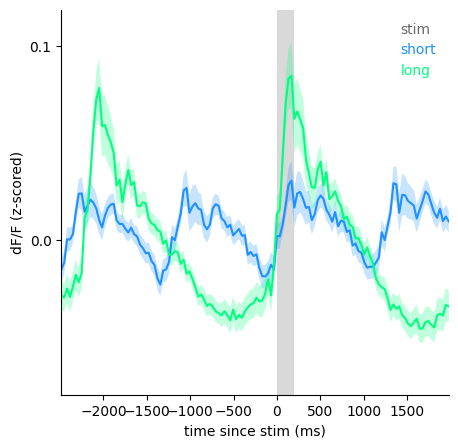

In [59]:
color0 = 'dimgrey'
color1 = 'dodgerblue'
color2 = 'springgreen'

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

mean_0, sem_0 = get_mean_sem(neu_seq_win_0)
mean_1, sem_1 = get_mean_sem(neu_seq_win_1)
# compute bounds.
upper = np.nanmax([mean_0, mean_1]) + np.nanmax([sem_0, sem_1])
lower = np.nanmin([mean_0, mean_1]) - np.nanmax([sem_0, sem_1])
# plot stimulus.
ax.fill_between(
    stim_seq[int(stim_seq.shape[0]/2),:],
    lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
    color=color0, edgecolor='none', alpha=0.25, step='mid')
# plot neural traces.
plot_mean_sem(ax, neu_time_win, mean_0, sem_0, color1, None)
plot_mean_sem(ax, neu_time_win, mean_1, sem_1, color2, None)
# adjust layout.
adjust_layout_neu(ax)
ax.set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
ax.set_xlabel('time since stim (ms)')
add_legend(ax, [color0, color1, color2], ['stim', 'short', 'long'], None, None, None, 'upper right')

plt.show()

Another useful example is to find the neural data given the stimulus. For the short long session, If you are looking at the data 2 interval before stimulus onset and 2 interval after stimulus end, you can first index stim_seq and pass the time to get_frame_idx_from_time.

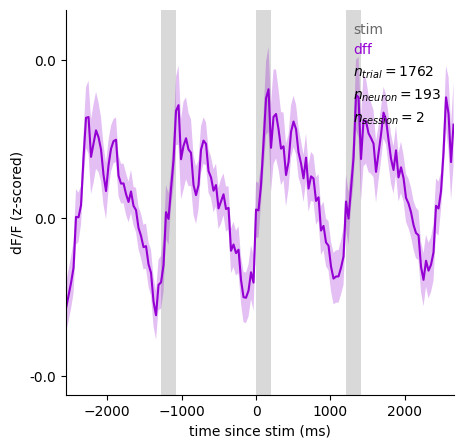

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# collect data.
[color0, _, color2, _], [neu_seq, _, stim_seq, _], _, [n_trials, n_neurons] = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[2,3,4,5], [0], None, None, [0], [0]],
    cate=cate, roi_id=None)

# find data points within the required range.
c_idx = int(stim_seq.shape[0]/2)
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, stim_seq[c_idx-2,0], stim_seq[c_idx+2,1])
neu_seq_win = neu_seq[:,l_idx:r_idx]
neu_time_win = alignment['neu_time'][l_idx:r_idx]

mean_neu, sem_neu = get_mean_sem(neu_seq_win)
# compute bounds.
upper = np.nanmax(mean_neu) + np.nanmax(sem_neu)
lower = np.nanmin(mean_neu) - np.nanmax(sem_neu)
# plot stimulus.
for si in [-1,0,1]:
    ax.fill_between(
        stim_seq[c_idx+si,:],
        lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
        color=color0, edgecolor='none', alpha=0.25, step='mid')
# plot neural traces.
plot_mean_sem(ax, neu_time_win, mean_neu, sem_neu, color2, None)
# adjust layout.
adjust_layout_neu(ax)
ax.set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
ax.set_xlabel('time since stim (ms)')
add_legend(ax, [color0, color2], ['stim', 'dff'], n_trials, n_neurons, n_sess, 'upper right')
plt.show()

## Response to individual image orientations

In the above case, [2,3,4,5] means the 4 orientations. If we want the averaged response across all neurons for each orientation, we can do only one image label as follows:

In [65]:
# collect data.
_, [neu_seq_2, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[2], [0], None, None, [0], [0]],
    cate=cate, roi_id=None)
_, [neu_seq_3, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[3], [0], None, None, [0], [0]],
    cate=cate, roi_id=None)
_, [neu_seq_4, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[4], [0], None, None, [0], [0]],
    cate=cate, roi_id=None)
_, [neu_seq_5, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[5], [0], None, None, [0], [0]],
    cate=cate, roi_id=None)

Then everything else remains similar.

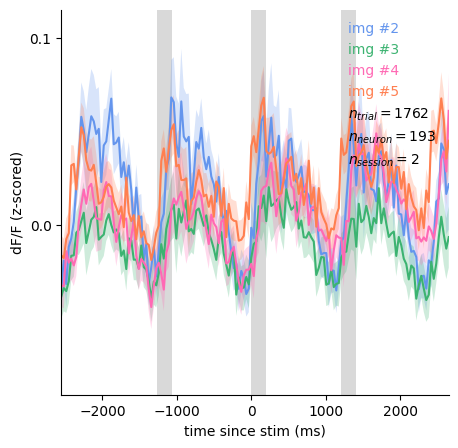

In [66]:
colors = ['cornflowerblue', 'mediumseagreen', 'hotpink', 'coral']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# find data points within the required range.
c_idx = int(stim_seq.shape[0]/2)
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, stim_seq[c_idx-2,0], stim_seq[c_idx+2,1])
neu_time_win = alignment['neu_time'][l_idx:r_idx]

mean_2, sem_2 = get_mean_sem(neu_seq_2[:,l_idx:r_idx])
mean_3, sem_3 = get_mean_sem(neu_seq_3[:,l_idx:r_idx])
mean_4, sem_4 = get_mean_sem(neu_seq_4[:,l_idx:r_idx])
mean_5, sem_5 = get_mean_sem(neu_seq_5[:,l_idx:r_idx])
# compute bounds.
upper = np.nanmax([mean_2, mean_3, mean_4, mean_5]) + np.nanmax([sem_2, sem_3, sem_4, sem_5])
lower = np.nanmin([mean_2, mean_3, mean_4, mean_5]) - np.nanmax([sem_2, sem_3, sem_4, sem_5])

# plot stimulus.
for si in [-1,0,1]:
    ax.fill_between(
        stim_seq[c_idx+si,:],
        lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
        color=color0, edgecolor='none', alpha=0.25, step='mid')
# plot neural traces.
plot_mean_sem(ax, neu_time_win, mean_2, sem_2, colors[0], None)
plot_mean_sem(ax, neu_time_win, mean_3, sem_3, colors[1], None)
plot_mean_sem(ax, neu_time_win, mean_4, sem_4, colors[2], None)
plot_mean_sem(ax, neu_time_win, mean_5, sem_5, colors[3], None)
# adjust layout.
adjust_layout_neu(ax)
ax.set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
ax.set_xlabel('time since stim (ms)')
add_legend(ax, colors, ['img #'+str(i) for i in [2,3,4,5]], n_trials, n_neurons, n_sess, 'upper right')
plt.show()

## Reponse to image change

The number in img_seq_label means the following for the center stimulus:
* 2: standard interval with image orientation 1.
* 3: standard interval with image orientation 2.
* 4: standard interval with image orientation 3.
* 5: standard interval with image orientation 4.
* -2: standard interval with image change to orientation 1.
* -3: standard interval with image change to orientation 2.
* -4: standard interval with image change to orientation 3.
* -5: standard interval with image change to orientation 4.
* -1: oddball interval with the same image orientation as surrounding.

Now instead of averaging across the same image orientation, we show the average across the change to a specific image orientation. Also, instead of short block above, we plot the result in long block. t=0 is when the image change happens.

In [92]:
# collect data.
_, [neu_seq_2, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-2], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)
_, [neu_seq_3, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-3], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)
_, [neu_seq_4, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-4], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)
_, [neu_seq_5, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-5], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)

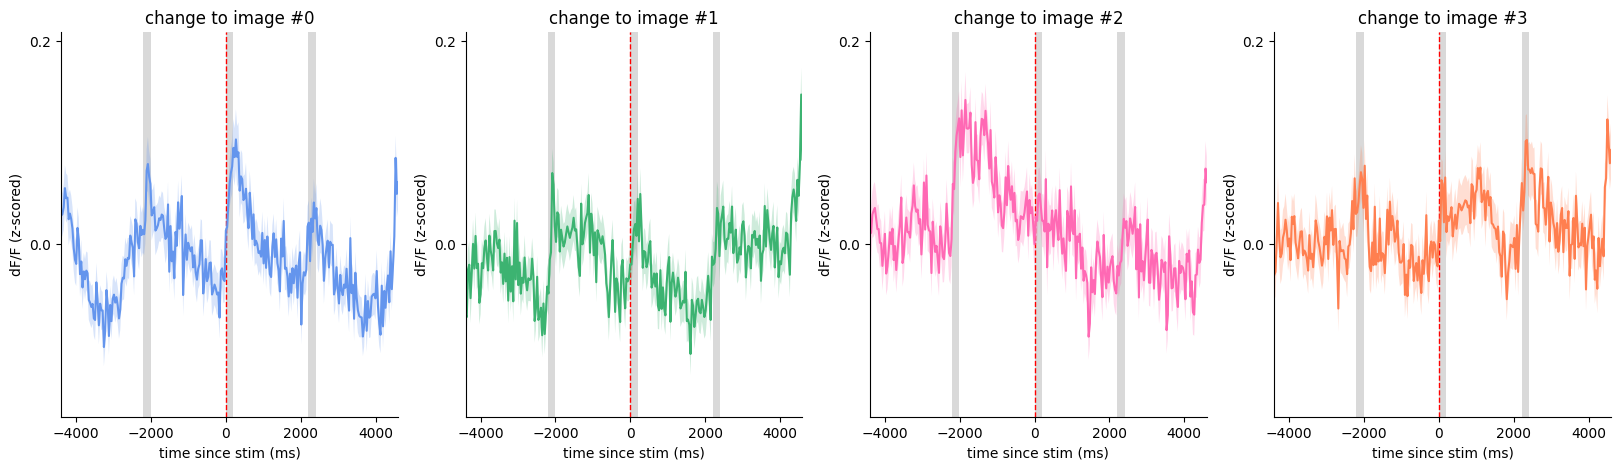

In [93]:
colors = ['cornflowerblue', 'mediumseagreen', 'hotpink', 'coral']
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# find data points within the required range.
c_idx = int(stim_seq.shape[0]/2)
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, stim_seq[c_idx-2,0], stim_seq[c_idx+2,1])
neu_time_win = alignment['neu_time'][l_idx:r_idx]

mean_2, sem_2 = get_mean_sem(neu_seq_2[:,l_idx:r_idx])
mean_3, sem_3 = get_mean_sem(neu_seq_3[:,l_idx:r_idx])
mean_4, sem_4 = get_mean_sem(neu_seq_4[:,l_idx:r_idx])
mean_5, sem_5 = get_mean_sem(neu_seq_5[:,l_idx:r_idx])
# compute bounds.
upper = np.nanmax([mean_2, mean_3, mean_4, mean_5]) + np.nanmax([sem_2, sem_3, sem_4, sem_5])
lower = np.nanmin([mean_2, mean_3, mean_4, mean_5]) - np.nanmax([sem_2, sem_3, sem_4, sem_5])

for ax in axs:
    # plot stimulus.
    for si in [-1,0,1]:
        ax.fill_between(
            stim_seq[c_idx+si,:],
            lower - 0.1*(upper-lower), upper + 0.1*(upper-lower),
            color=color0, edgecolor='none', alpha=0.25, step='mid')
    ax.axvline(0, color='red', lw=1, linestyle='--')
# plot neural traces.
plot_mean_sem(axs[0], neu_time_win, mean_2, sem_2, colors[0], None)
plot_mean_sem(axs[1], neu_time_win, mean_3, sem_3, colors[1], None)
plot_mean_sem(axs[2], neu_time_win, mean_4, sem_4, colors[2], None)
plot_mean_sem(axs[3], neu_time_win, mean_5, sem_5, colors[3], None)
# adjust layout.
for ai in range(4):
    adjust_layout_neu(axs[ai])
    axs[ai].set_ylim([lower - 0.1*(upper-lower), upper + 0.1*(upper-lower)])
    axs[ai].set_xlabel('time since stim (ms)')
    axs[ai].set_title(f'change to image #{ai}')
plt.show()

A simple quantification is to find the response value around image orientation change. This can be done based on get_mean_sem_win. Supposed the evaluation window is $[0, 400]$ ms starting at image change at t=0.

In [104]:
win_eval = [0, 400]

# collect data.
_, [neu_seq_2, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-2], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)
_, [neu_seq_3, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-3], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)
_, [neu_seq_4, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-4], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)
_, [neu_seq_5, _, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-5], [1], None, None, [0], [0]],
    cate=cate, roi_id=None)

neu_2, _, _ = get_mean_sem_win(neu_seq_2, alignment['neu_time'], 0, win_eval[0], win_eval[1], 'mean')
neu_3, _, _ = get_mean_sem_win(neu_seq_3, alignment['neu_time'], 0, win_eval[0], win_eval[1], 'mean')
neu_4, _, _ = get_mean_sem_win(neu_seq_4, alignment['neu_time'], 0, win_eval[0], win_eval[1], 'mean')
neu_5, _, _ = get_mean_sem_win(neu_seq_5, alignment['neu_time'], 0, win_eval[0], win_eval[1], 'mean')

Now plot the response distribution across neurons for each image change.

Text(0, 0.5, 'dF/F (z-scored)')

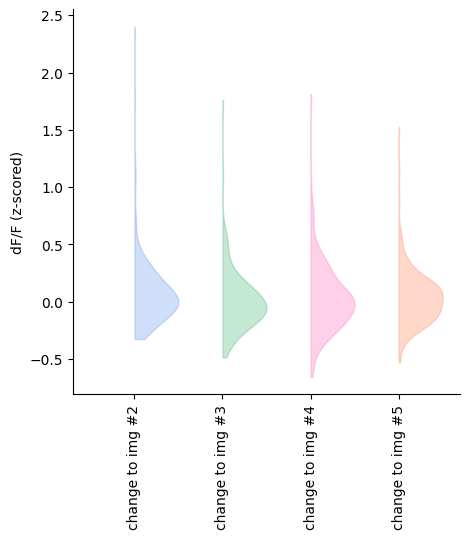

In [115]:
colors = ['cornflowerblue', 'mediumseagreen', 'hotpink', 'coral']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_half_violin(ax, neu_2, 0, colors[0], 'right')
plot_half_violin(ax, neu_3, 1, colors[1], 'right')
plot_half_violin(ax, neu_4, 2, colors[2], 'right')
plot_half_violin(ax, neu_5, 3, colors[3], 'right')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['change to img #'+str(i) for i in [2,3,4,5]], rotation=90)
ax.set_ylabel('dF/F (z-scored)')

## Pseudo trial response around image change

If further quantification analysis requires single trial data, it is recommended to use pseudo trial construction to reduce noise. This can be as the following.

In [116]:
# collect data.
_, [neu_seq_2, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-2], [1], None, None, [0], [0]],
    sub_sampling=True,
    cate=cate, roi_id=None)
_, [neu_seq_3, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-3], [1], None, None, [0], [0]],
    sub_sampling=True,
    cate=cate, roi_id=None)
_, [neu_seq_4, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-4], [1], None, None, [0], [0]],
    sub_sampling=True,
    cate=cate, roi_id=None)
_, [neu_seq_5, stim_seq, _], _, _ = get_neu_trial(
    alignment, list_labels, list_significance, list_stim_labels,
    trial_param=[[-5], [1], None, None, [0], [0]],
    sub_sampling=True,
    cate=cate, roi_id=None)

All neu_seq has the shape of $n_{trials} \times n_{neurons} \times n_{times}$. Here $n_{trials}$ is not the actual number of single trial, but pseudo trial.

In [117]:
print('shape of pseudo trial for image change to orientation 1: {}'.format(neu_seq_2.shape))
print('shape of pseudo trial for image change to orientation 2: {}'.format(neu_seq_3.shape))
print('shape of pseudo trial for image change to orientation 3: {}'.format(neu_seq_4.shape))
print('shape of pseudo trial for image change to orientation 4: {}'.format(neu_seq_5.shape))

shape of pseudo trial for image change to orientation 1: (252, 193, 600)
shape of pseudo trial for image change to orientation 2: (252, 193, 600)
shape of pseudo trial for image change to orientation 3: (252, 193, 600)
shape of pseudo trial for image change to orientation 4: (252, 193, 600)
